### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

### Read Data

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train.parquet", replace_negative_one=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test.parquet", replace_negative_one=True)

Shape of data: (5531451, 190)
Shape of data: (11363762, 190)
CPU times: user 14.4 s, sys: 16.6 s, total: 31 s
Wall time: 20.7 s


In [8]:
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
%%time
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 1.41 s, sys: 3.17 s, total: 4.57 s
Wall time: 7.97 s


In [10]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


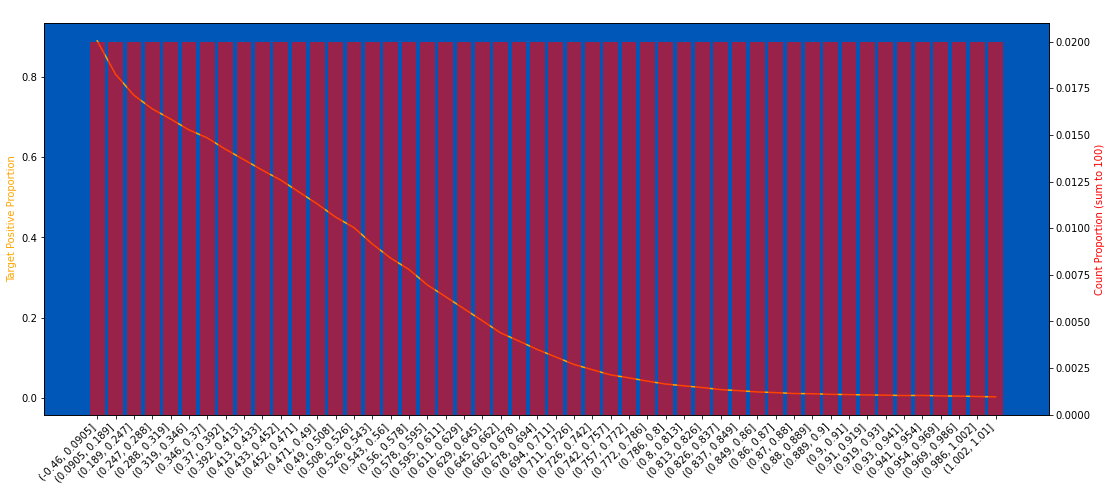

In [11]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [12]:
train["P_2"] = train["P_2"].round(2)
test["P_2"] = test["P_2"].round(2)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


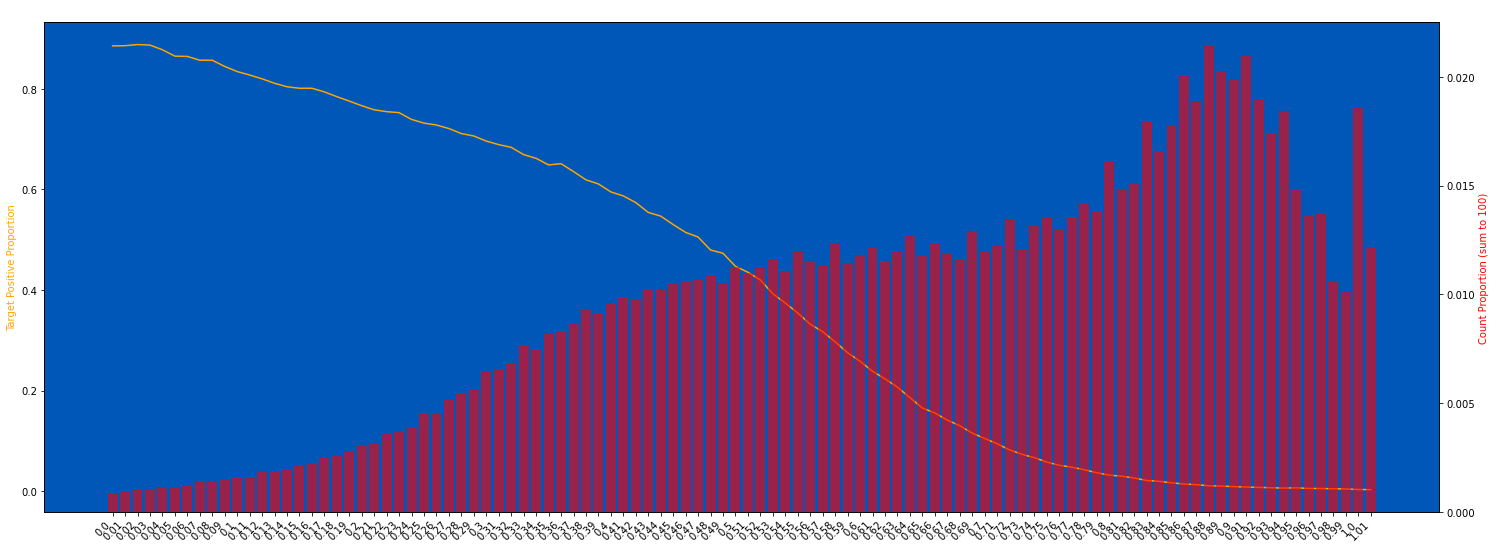

In [13]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


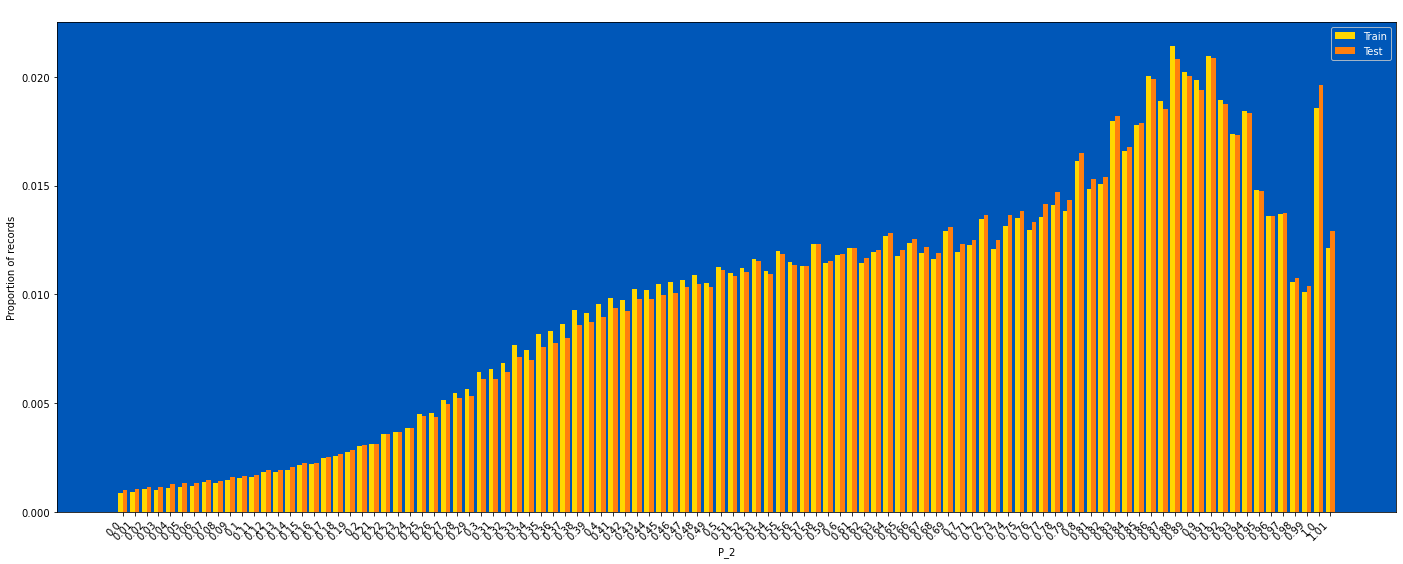

In [14]:
plot_train_test_distribution(train, test, "P_2", nunique_thr=150, figsize=(24, 10))

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


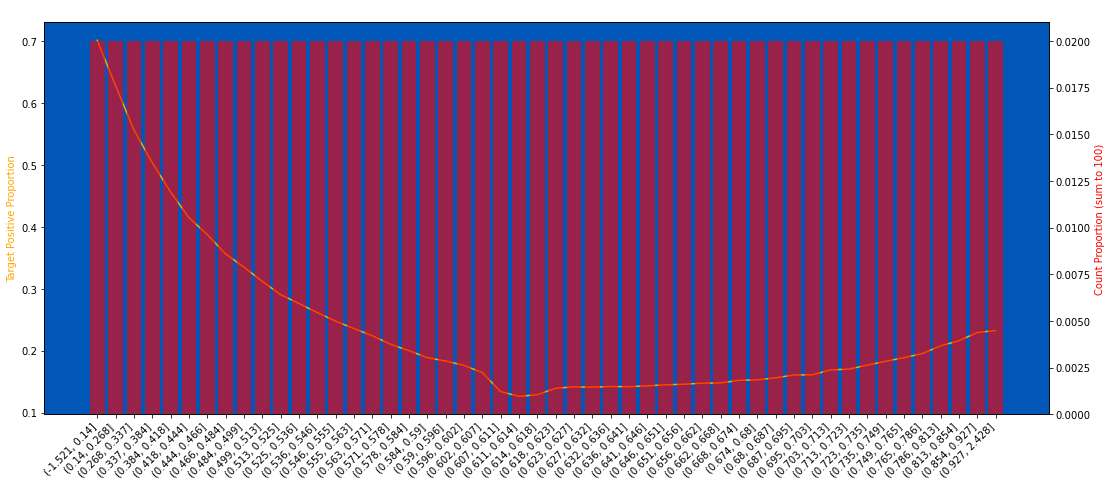

In [15]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [16]:
train["P_3"] = train["P_3"].round(2)
test["P_3"] = test["P_3"].round(2)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


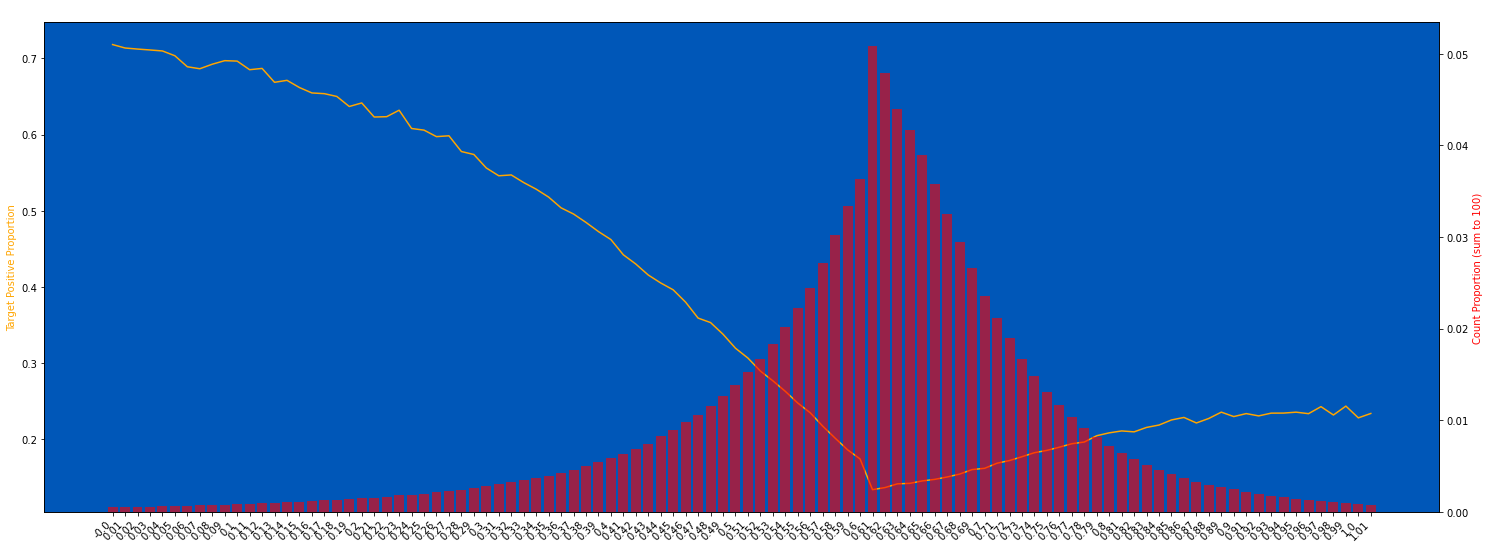

In [17]:
p3_summary = plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10), 
                               drop_outlier=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


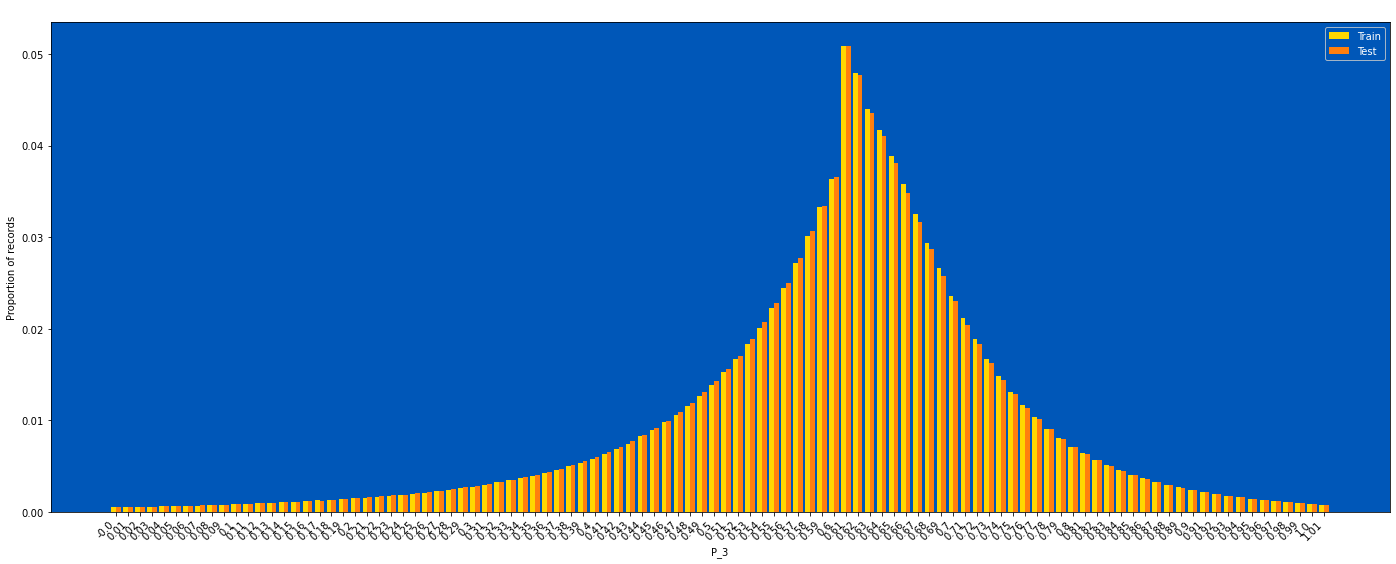

In [18]:
plot_train_test_distribution(train, test, "P_3", nunique_thr=340, figsize=(24, 10))

### P_3a

In [19]:
p3_summary.loc[p3_summary["P_3"].isin([0, 1])]

,P_3,target_mean,count_distribution,proportion_distribution
124,-0.0000,0.7181,2636,0.0005
224,1.0000,0.2282,4627,0.0009


In [20]:
p3_summary.loc[p3_summary["P_3"].between(0.605, 0.615)]

,P_3,target_mean,count_distribution,proportion_distribution
185,0.6100,0.1340,266076,0.0509


In [21]:
left_grad = (0.134 - 0.7181) / (0 - 0.61)
right_grad = (0.2282 - 0.134) / (1 - 0.61)

In [22]:
left_grad, right_grad

(0.9575409836065574, 0.24153846153846148)

In [23]:
train["P_3a"] = (train["P_3"] - 0.61).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10
test["P_3a"] = (test["P_3"] - 0.61).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


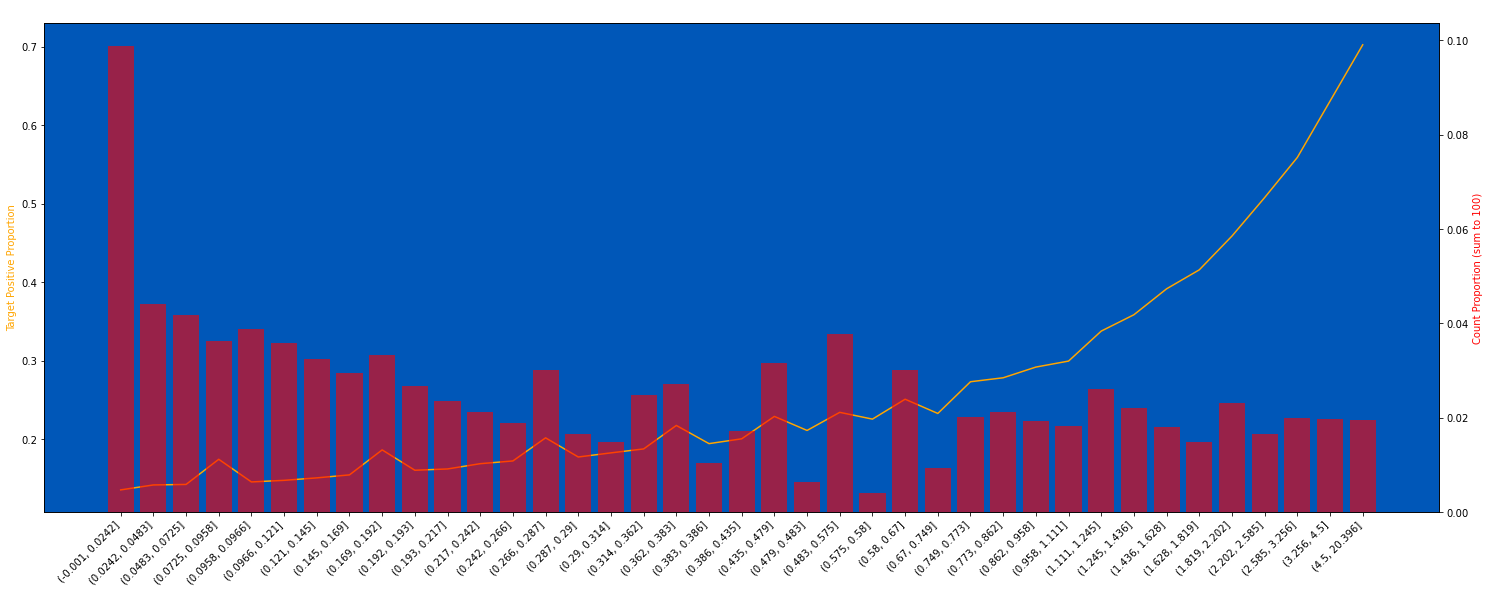

In [24]:
plot_target_check(train, "P_3a", q=50, use_raw_bin=True, nunique_thr=150, figsize=(25, 10))

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


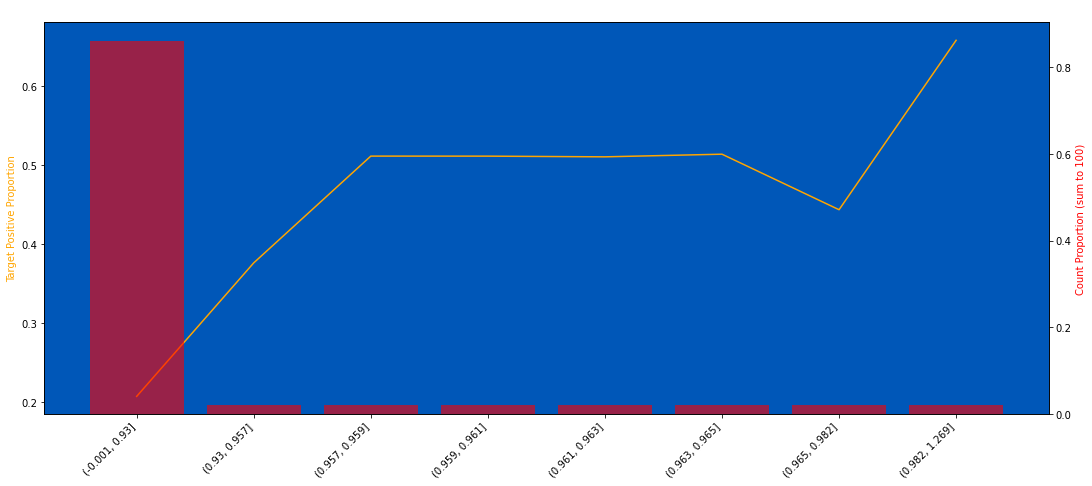

In [25]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [26]:
train["P_4"] = train["P_4"].round(2)
test["P_4"] = test["P_4"].round(2)

Bottom 1% and Top 1% are dropped from this chart


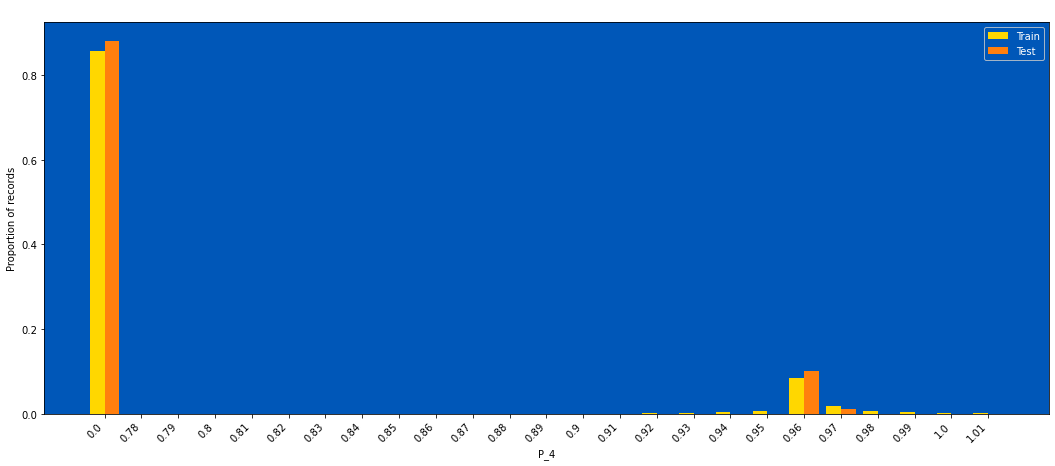

In [27]:
plot_train_test_distribution(train, test, "P_4")

In [28]:
train["P_4"] = train["P_4"].replace(0, np.nan)
test["P_4"] = test["P_4"].replace(0, np.nan)

Bottom 1% and Top 1% are dropped from this chart


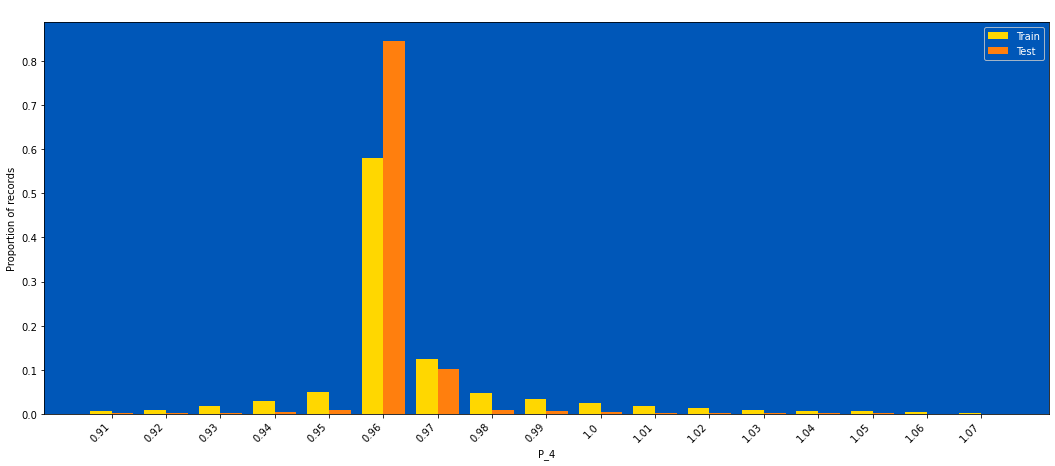

In [29]:
plot_train_test_distribution(train, test, "P_4")

4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


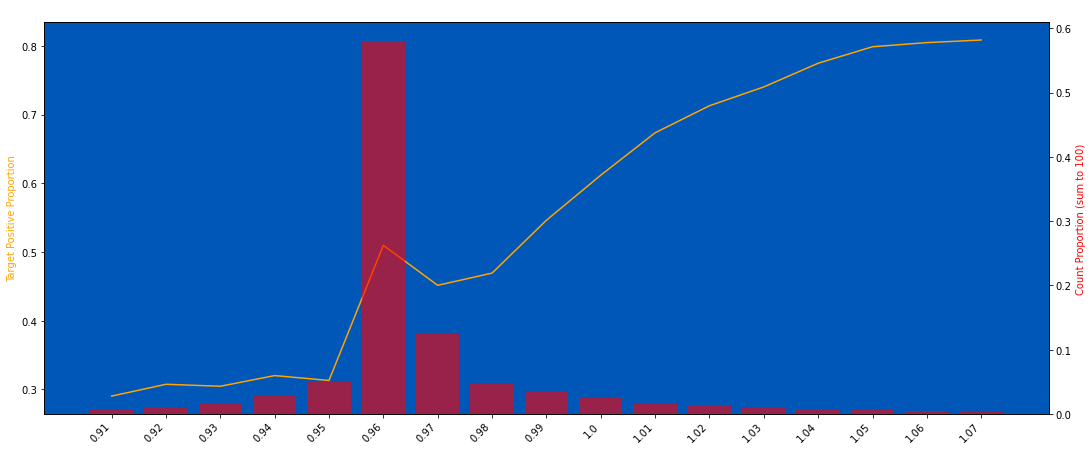

In [30]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


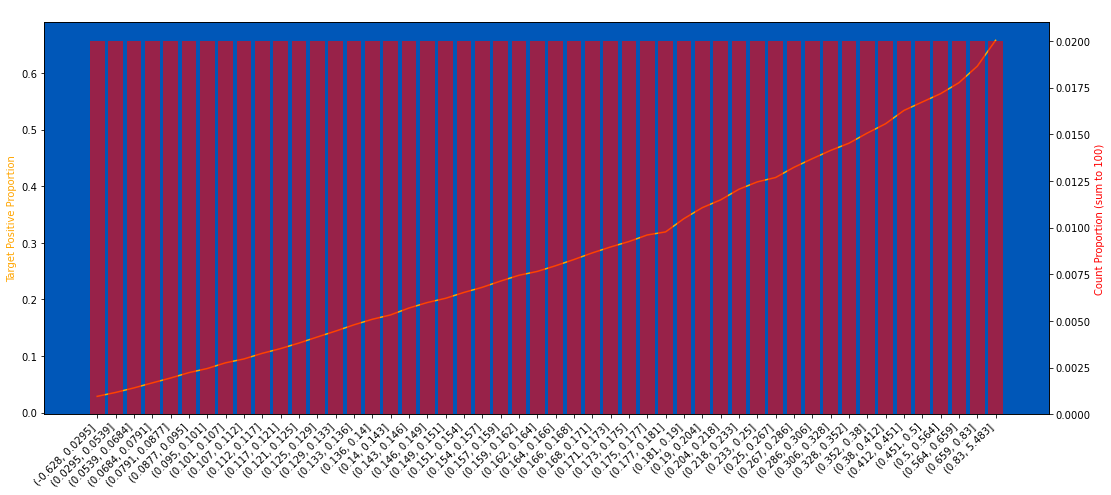

In [31]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [32]:
train["S_3"] = train["S_3"].round(2)
test["S_3"] = test["S_3"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


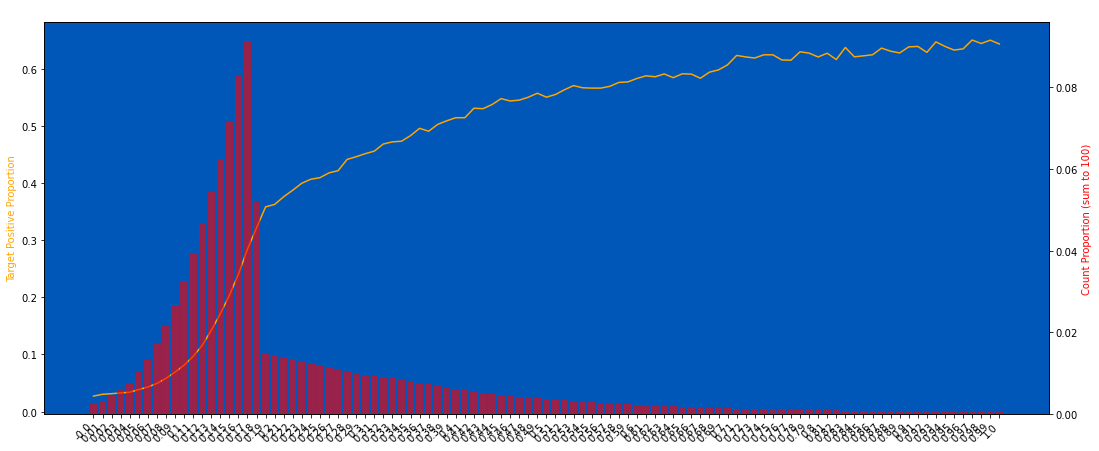

In [33]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=400, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


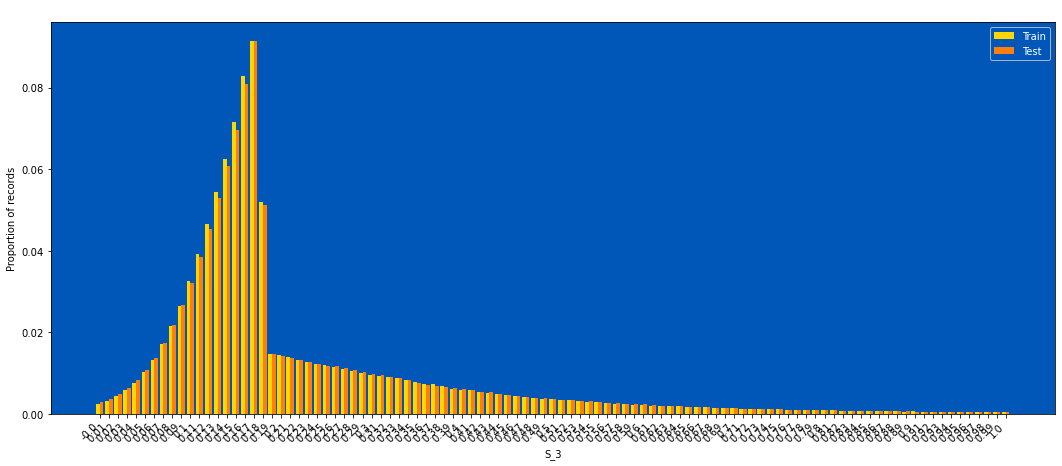

In [34]:
plot_train_test_distribution(train, test, "S_3", nunique_thr=500)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


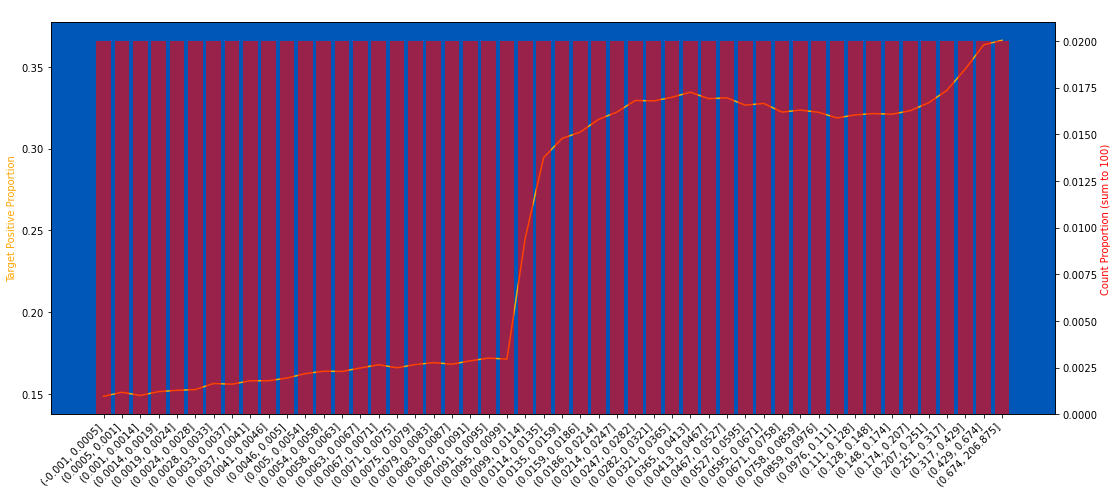

In [35]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [36]:
train["S_5"] = train["S_5"].round(2)
test["S_5"] = test["S_5"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


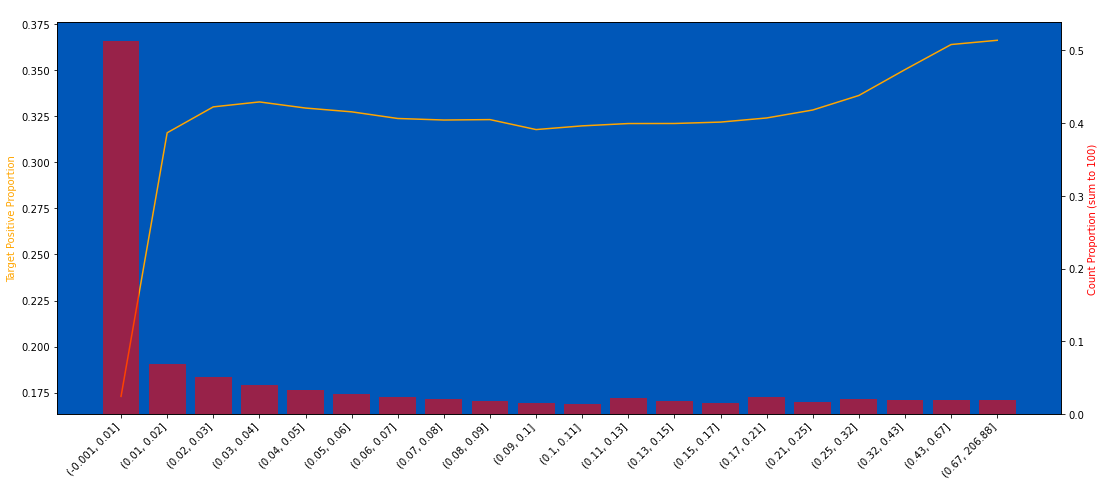

In [37]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

### S_6

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


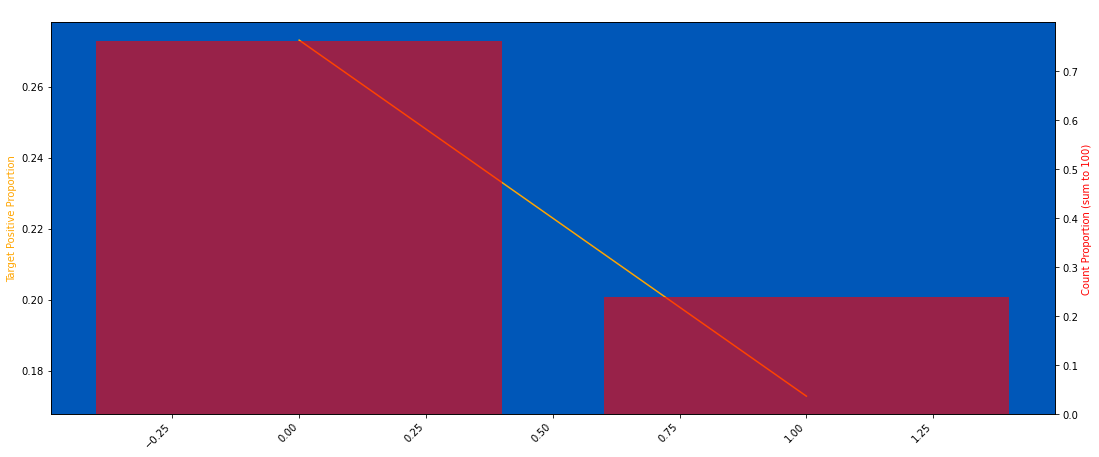

In [38]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


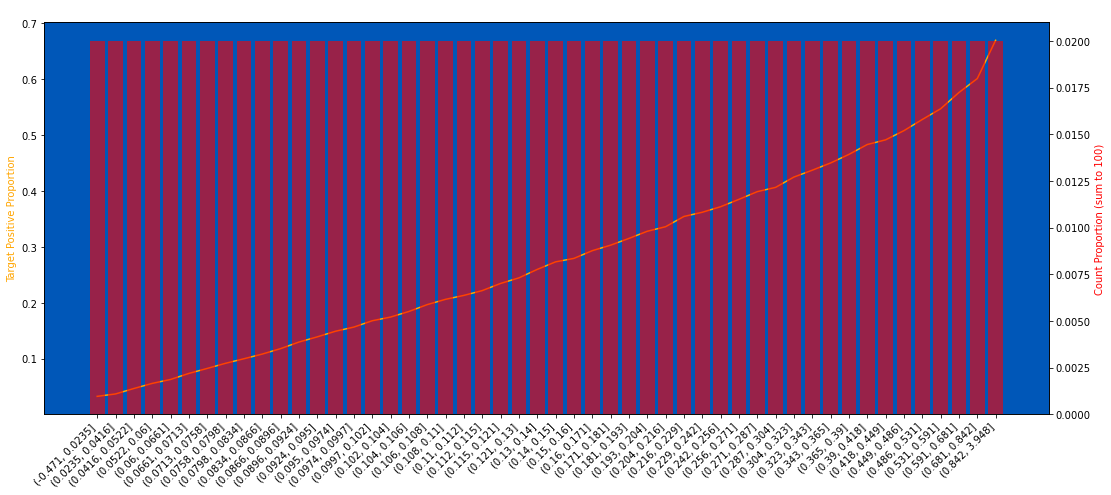

In [39]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [40]:
train["S_7"] = train["S_7"].round(2)
test["S_7"] = test["S_7"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


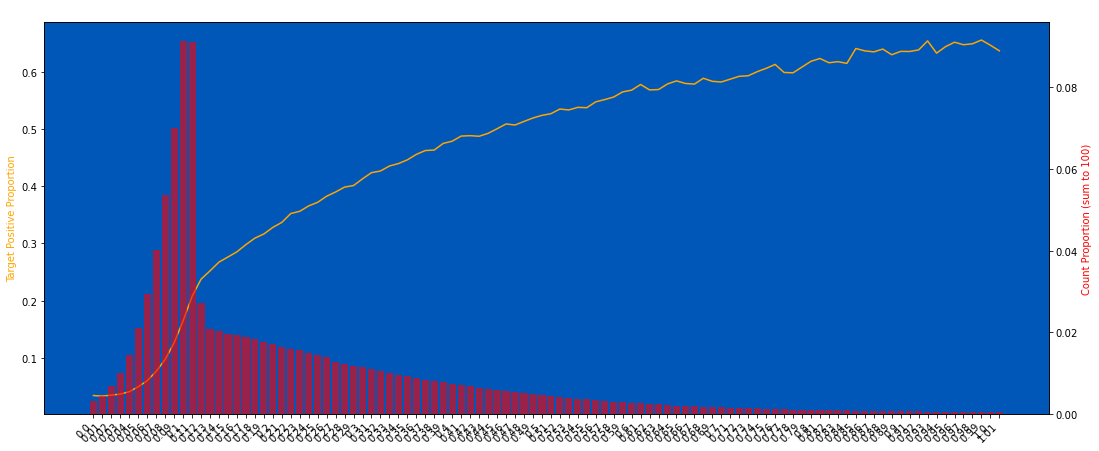

In [41]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


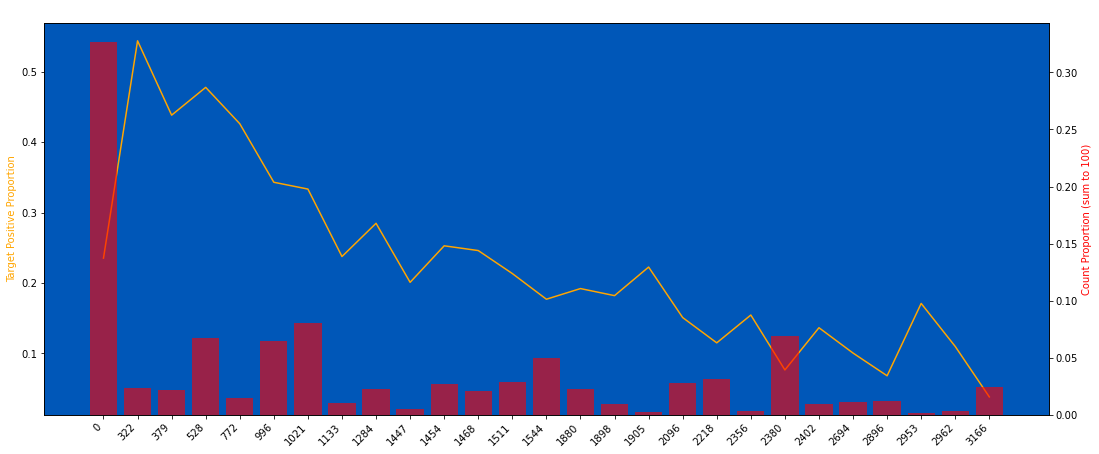

In [42]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


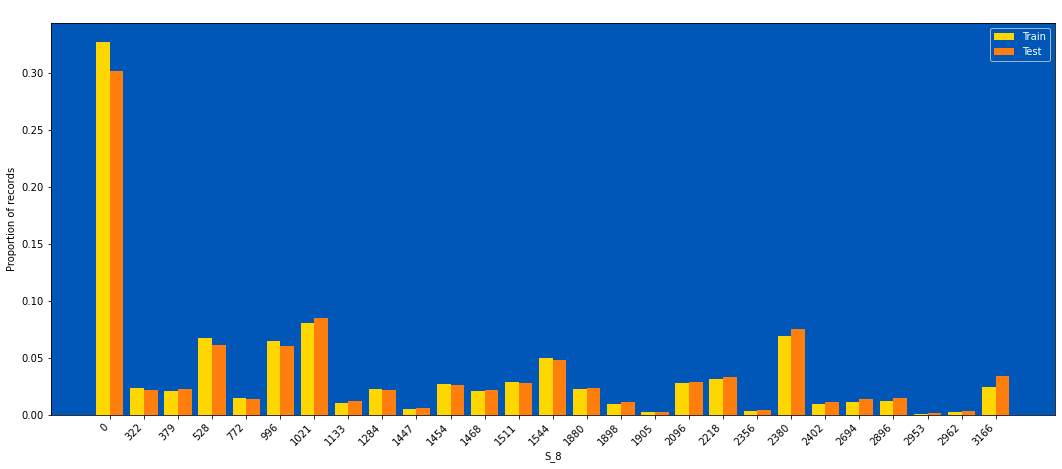

In [43]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500)

In [44]:
s8_mapping_dict = dict(zip(sorted(train["S_8"].unique()), range(train["S_8"].nunique())))

In [45]:
train["S_8"] = train["S_8"].map(s8_mapping_dict).replace(0, np.nan)
test["S_8"] = test["S_8"].map(s8_mapping_dict).replace(0, np.nan)

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


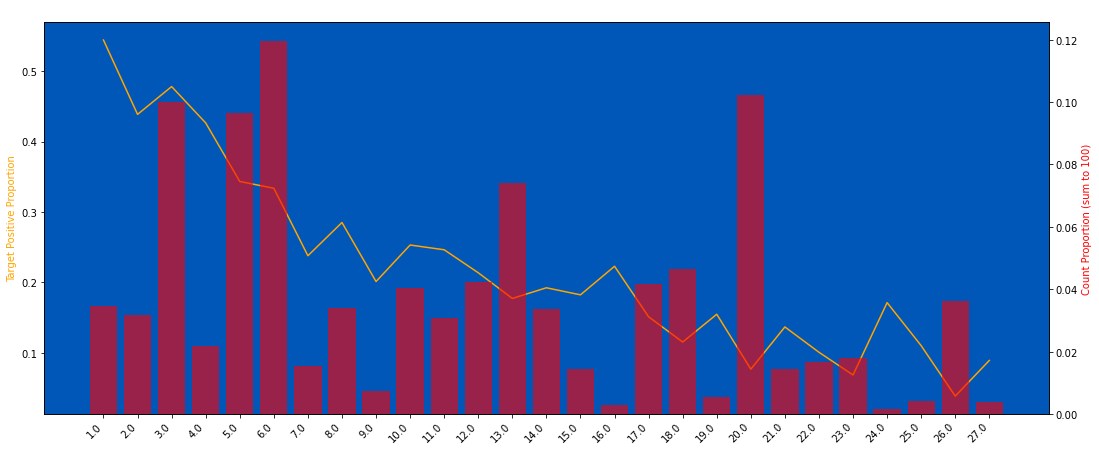

In [46]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


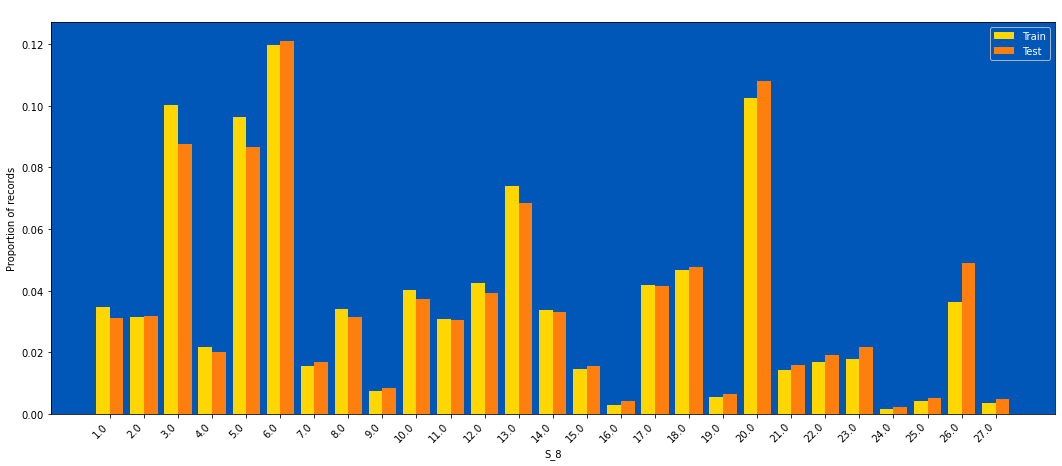

In [47]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


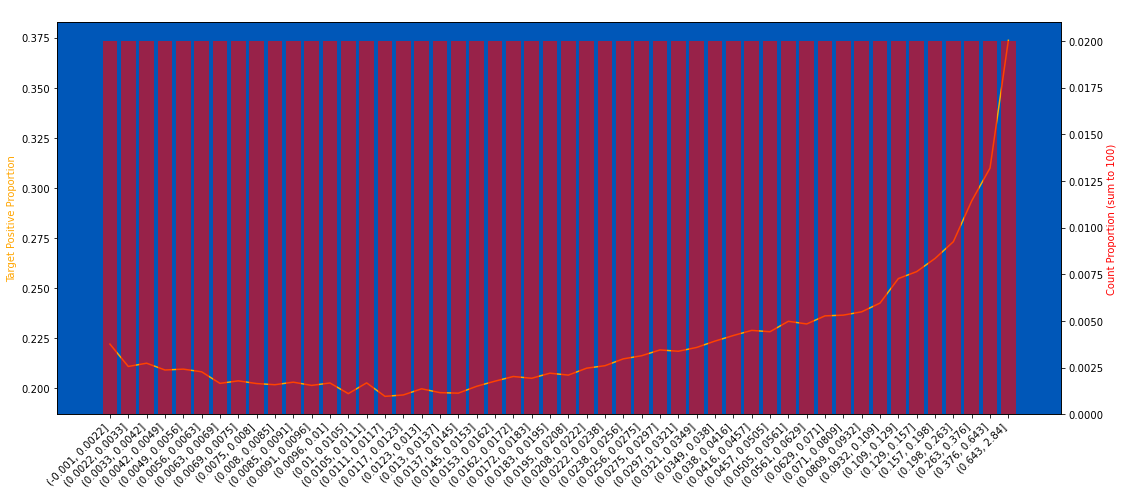

In [48]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [49]:
train["S_9"] = train["S_9"].round(2)
test["S_9"] = test["S_9"].round(2)

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


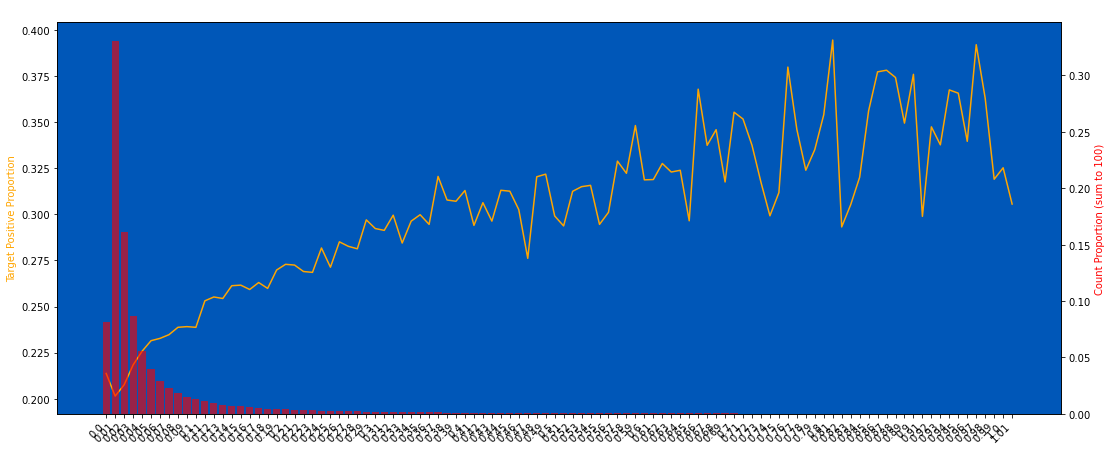

In [50]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


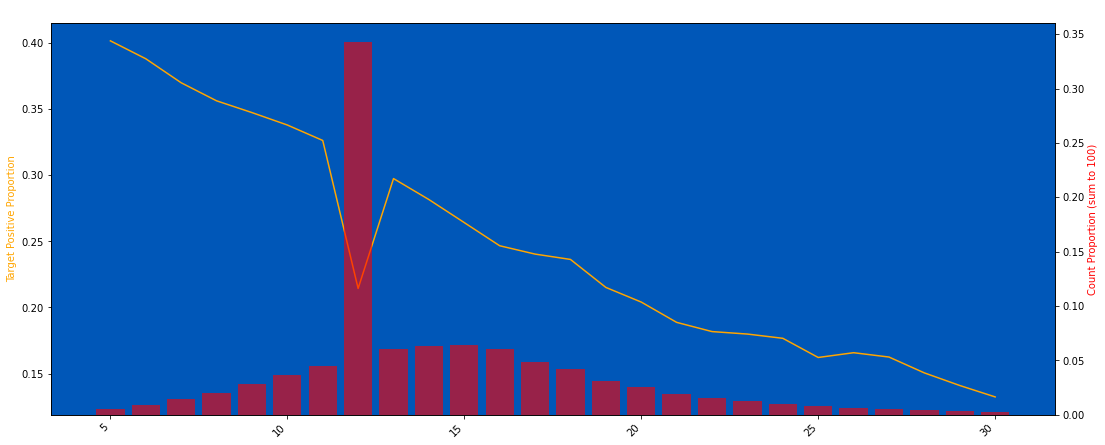

In [51]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


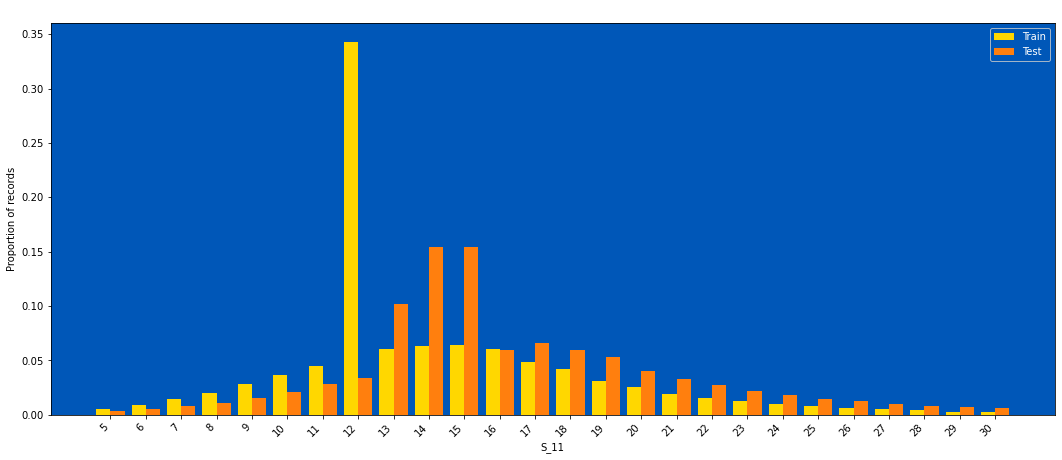

In [52]:
plot_train_test_distribution(train, test, "S_11", nunique_thr=500)

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


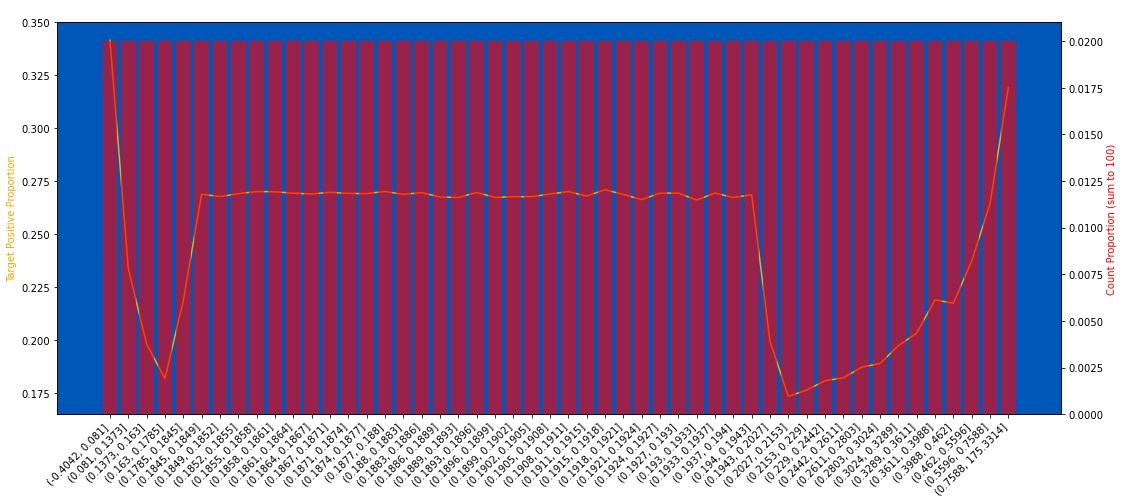

In [53]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [54]:
train.loc[train["S_12"].between(0.18, 0.2), "S_12"] = np.nan
test.loc[test["S_12"].between(0.18, 0.2), "S_12"] = np.nan

In [55]:
train["S_12"] = train["S_12"].round(2)
test["S_12"] = test["S_12"].round(2)

3612553 null count, 0.653 null proportion
0.2662 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


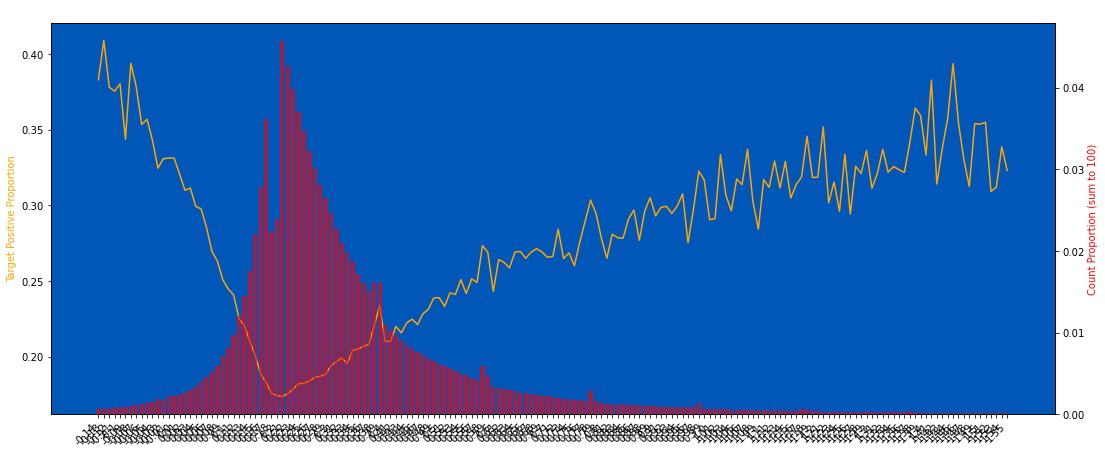

In [56]:
s12_summary = plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, return_df=True)

### S_12a

In [57]:
s12_summary.loc[s12_summary["S_12"] == s12_summary["S_12"].nsmallest(7).values[-1]]

,S_12,target_mean,count_distribution,proportion_distribution
32,-0.0800,0.3939,1871,0.0010


In [58]:
s12_summary.loc[s12_summary["S_12"] == s12_summary["S_12"].nlargest(11).values[-1]]

,S_12,target_mean,count_distribution,proportion_distribution
184,1.4500,0.3938,353,0.0002


In [59]:
s12_summary.loc[s12_summary["target_mean"] == s12_summary["target_mean"].min()]

,S_12,target_mean,count_distribution,proportion_distribution
60,0.2100,0.1737,87631,0.0457


In [60]:
left_grad = (0.1711 - 0.3939) / (-0.08 - 0.2)
right_grad = (0.3938 - 0.1711) / (1.45 - 0.2)

In [61]:
left_grad, right_grad

(0.7957142857142855, 0.17815999999999999)

In [62]:
train["S_12a"] = (train["S_12"] - 0.2).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10
test["S_12a"] = (test["S_12"] - 0.2).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10

3612553 null count, 0.653 null proportion
0.2662 of the targets have label = 1


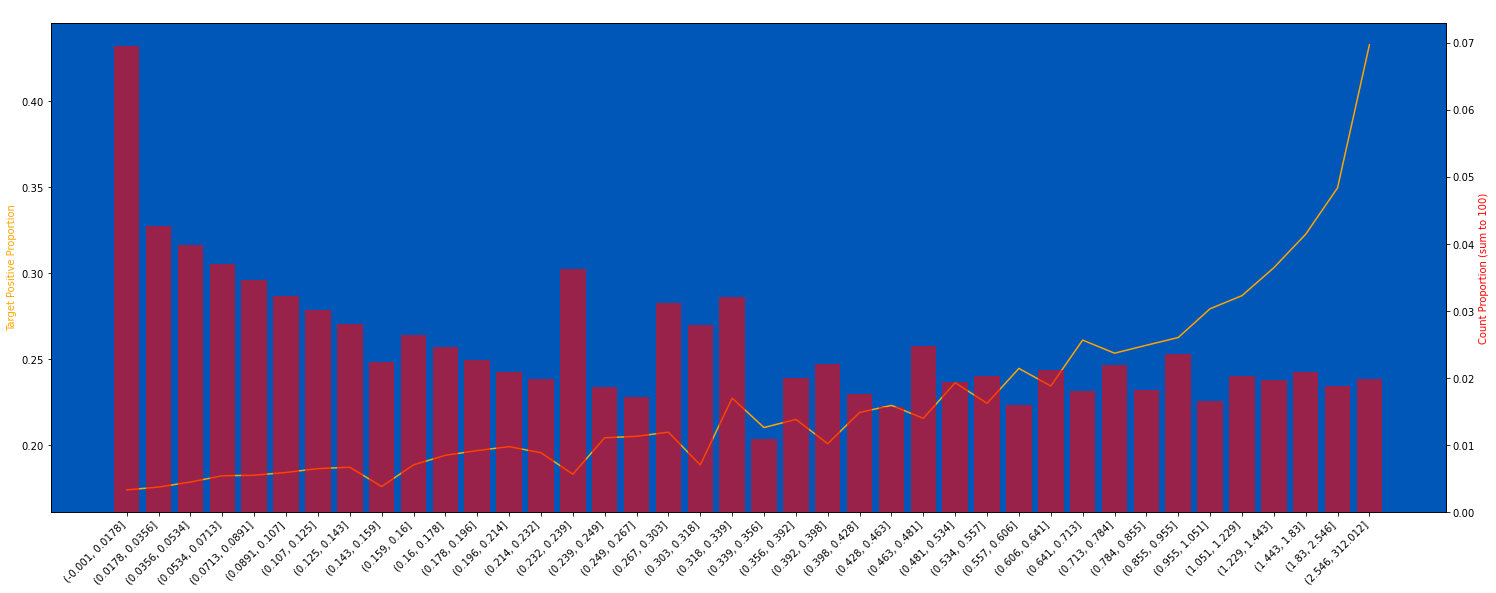

In [63]:
plot_target_check(train, "S_12a", q=50, use_raw_bin=True, nunique_thr=150, figsize=(25, 10))

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


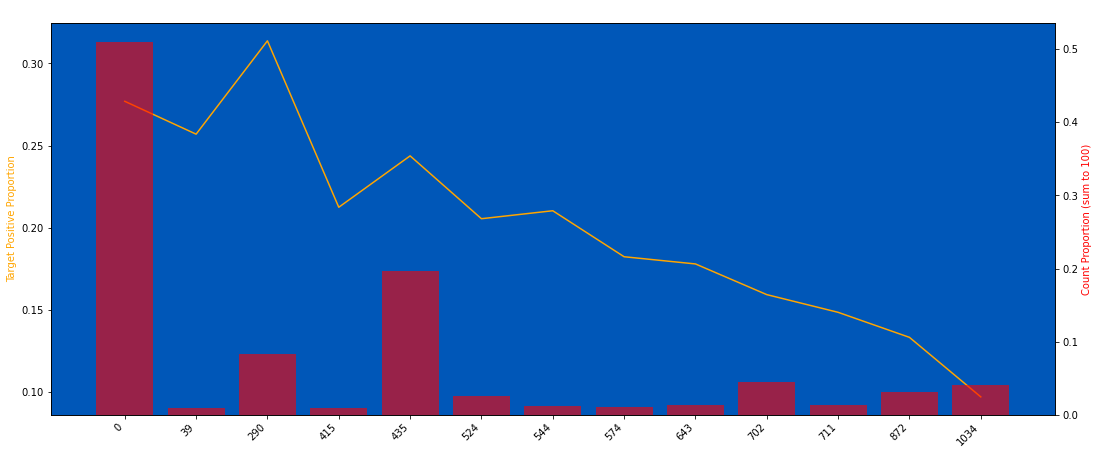

In [64]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


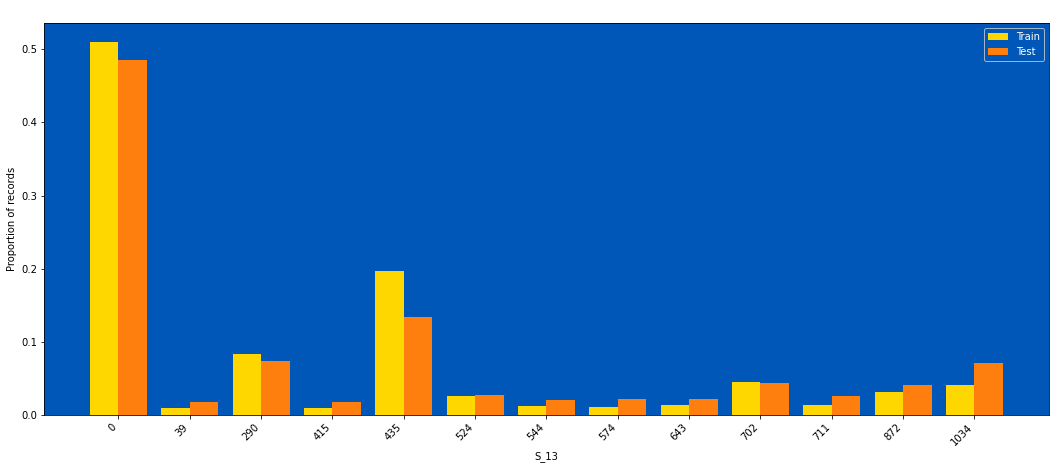

In [65]:
plot_train_test_distribution(train, test, "S_13", nunique_thr=500)

In [66]:
s13_mapping_dict = dict(zip(sorted(train["S_13"].unique()), range(train["S_13"].nunique())))

In [67]:
train["S_13"] = train["S_13"].map(s13_mapping_dict).replace(0, np.nan)
test["S_13"] = test["S_13"].map(s13_mapping_dict).replace(0, np.nan)

2822865 null count, 0.510 null proportion
0.2769 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


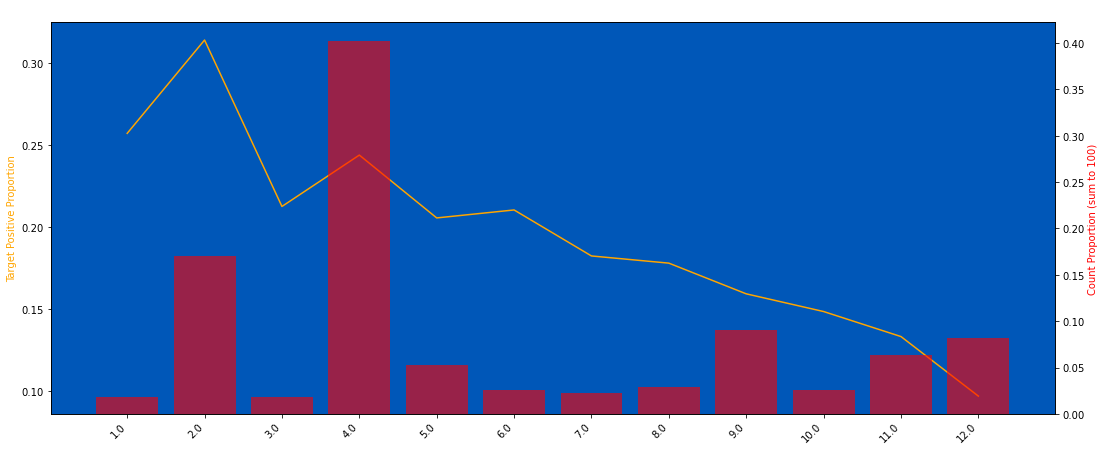

In [68]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


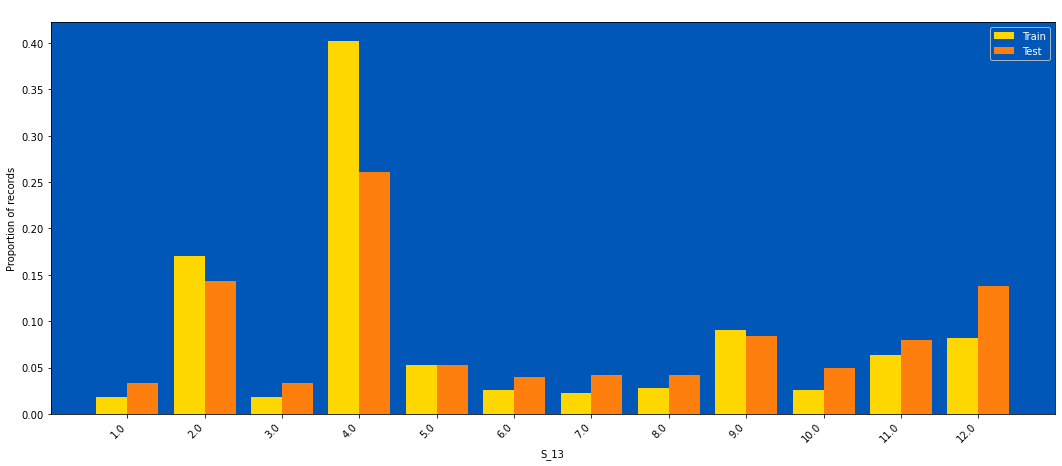

In [69]:
plot_train_test_distribution(train, test, "S_13", nunique_thr=500)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


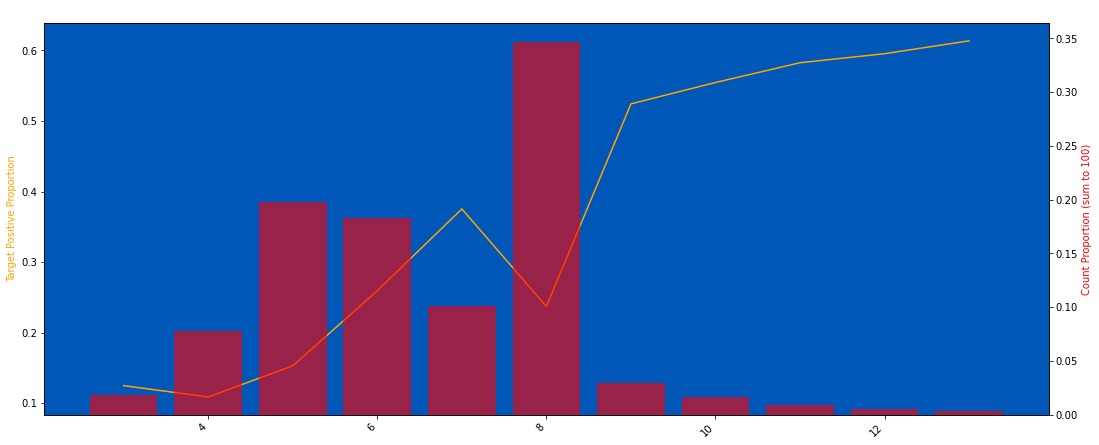

In [70]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


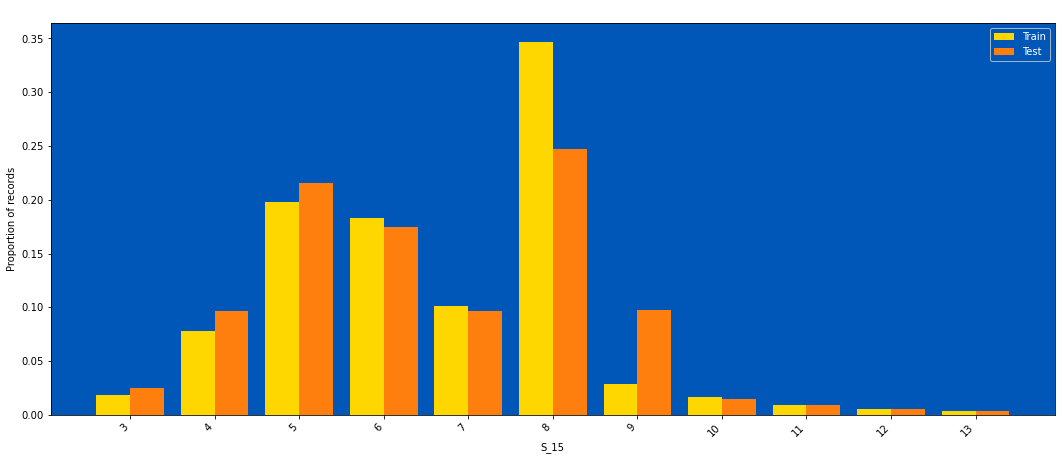

In [71]:
plot_train_test_distribution(train, test, "S_15", nunique_thr=500)

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


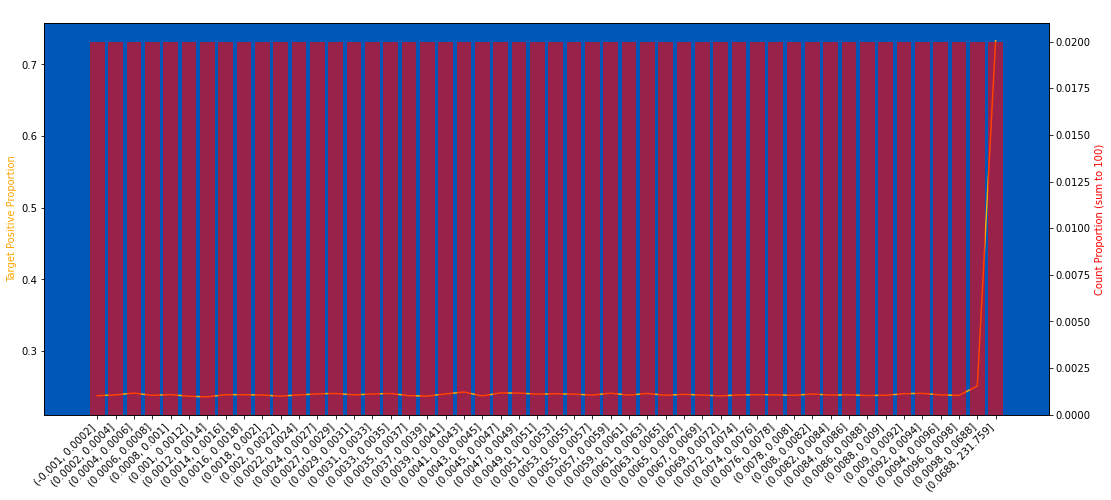

In [72]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [73]:
train["S_16"] = train["S_16"].round(2)
test["S_16"] = test["S_16"].round(2)

In [74]:
train["S_16"] = train["S_16"].replace(0, 0.01)
test["S_16"] = test["S_16"].replace(0, 0.01)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


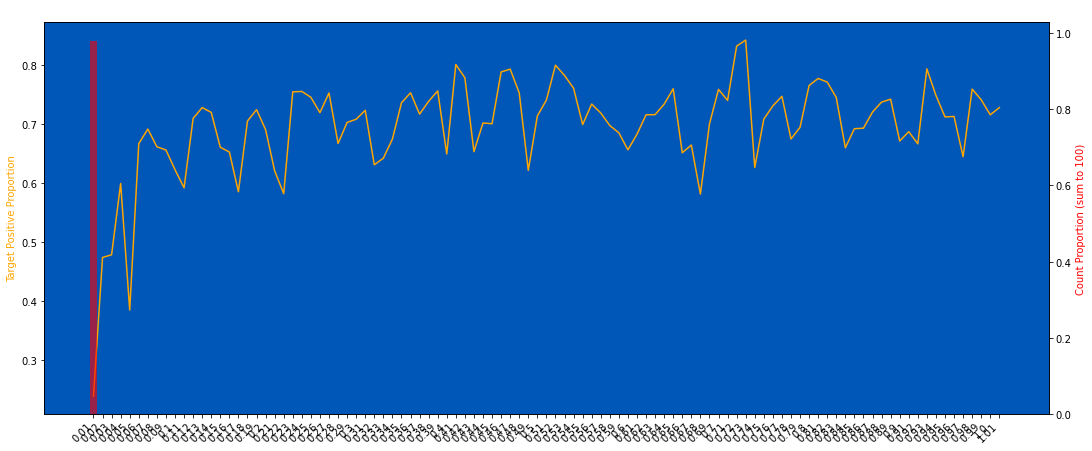

In [75]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True)

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


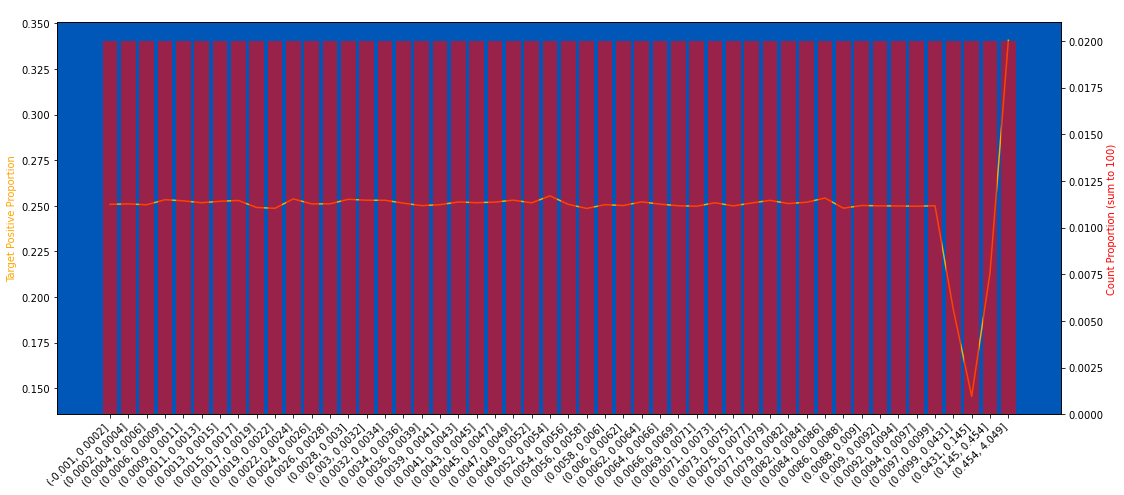

In [76]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [77]:
train["S_17"] = train["S_17"].round(2)
test["S_17"] = test["S_17"].round(2)

In [78]:
train["S_17"] = train["S_17"].replace(0.01, 0)
test["S_17"] = test["S_17"].replace(0.01, 0)

In [79]:
train["S_17"] = train["S_17"].replace(0, np.nan)
test["S_17"] = test["S_17"].replace(0, np.nan)

5159577 null count, 0.933 null proportion
0.2512 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


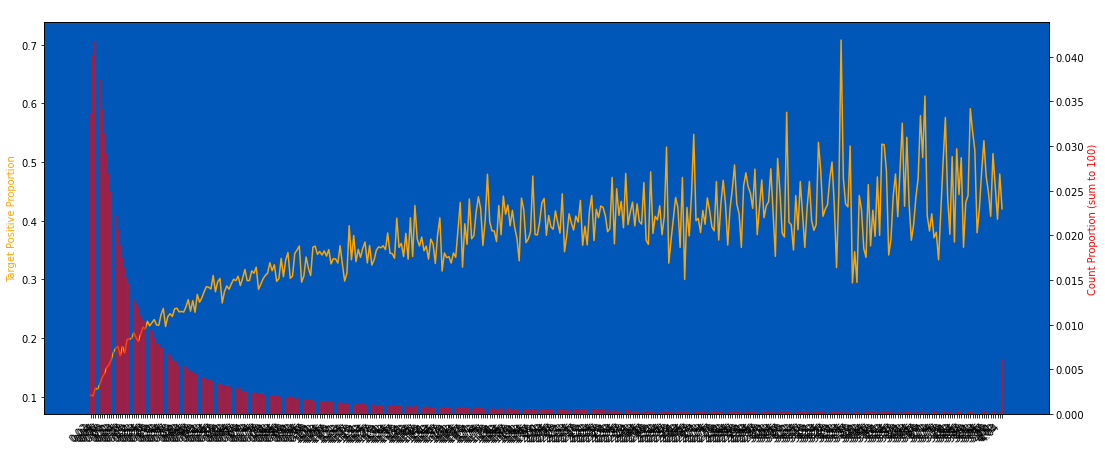

In [80]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True)

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


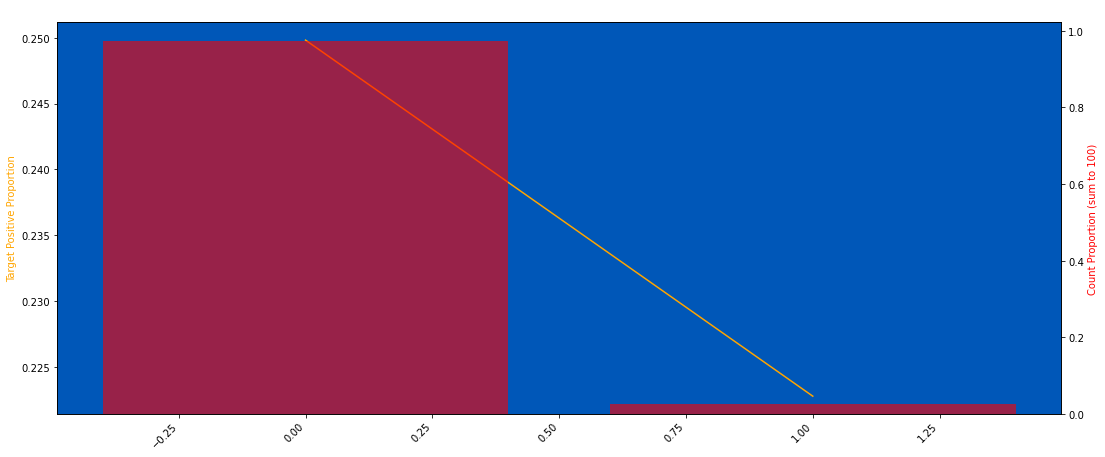

In [81]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


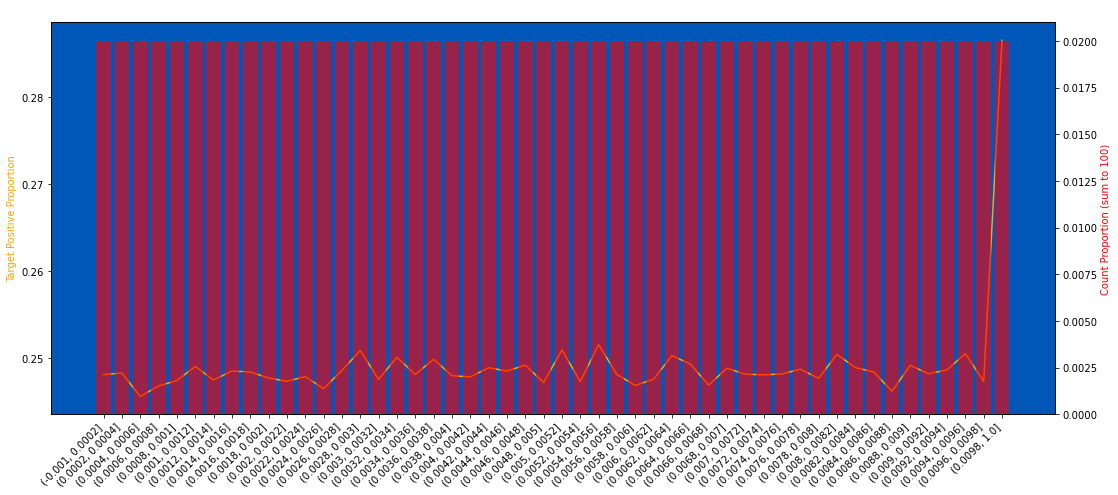

In [82]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [83]:
train["S_19"] = train["S_19"].round(2)
test["S_19"] = test["S_19"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


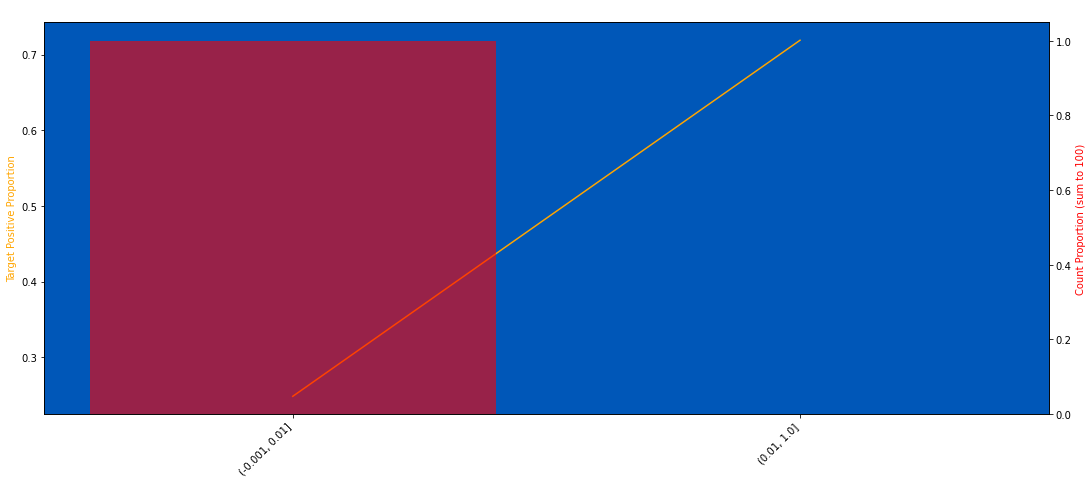

In [84]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=2)

### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


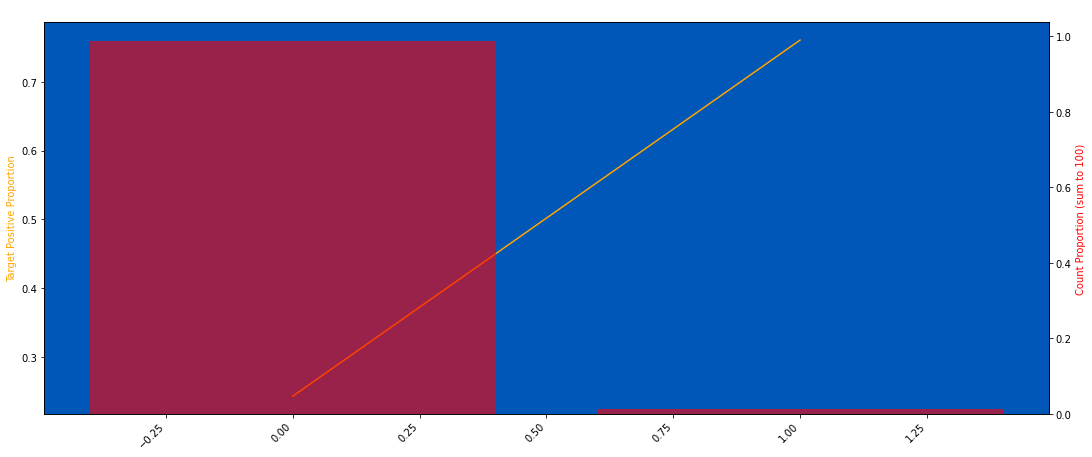

In [85]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


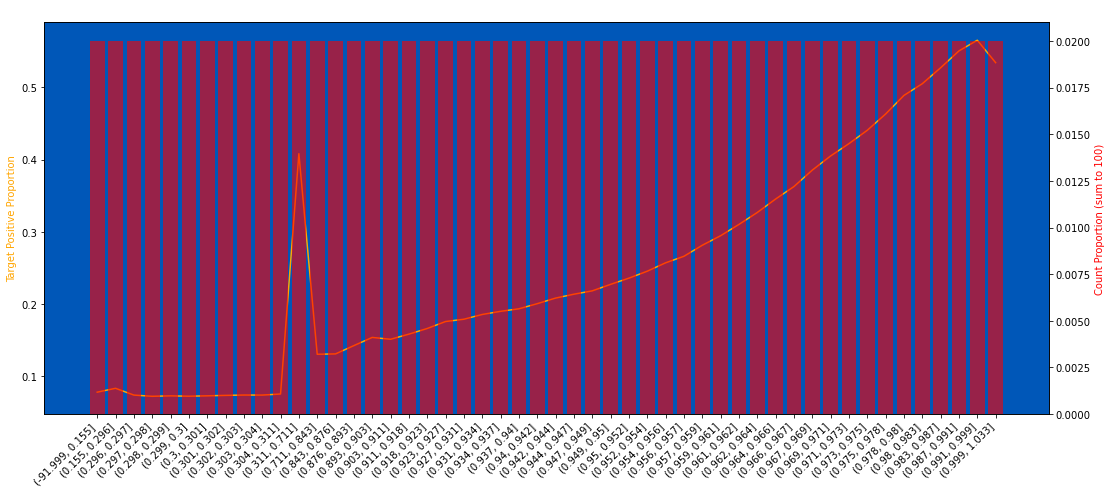

In [86]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [87]:
train["S_22"] = train["S_22"].round(2)
test["S_22"] = test["S_22"].round(2)

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


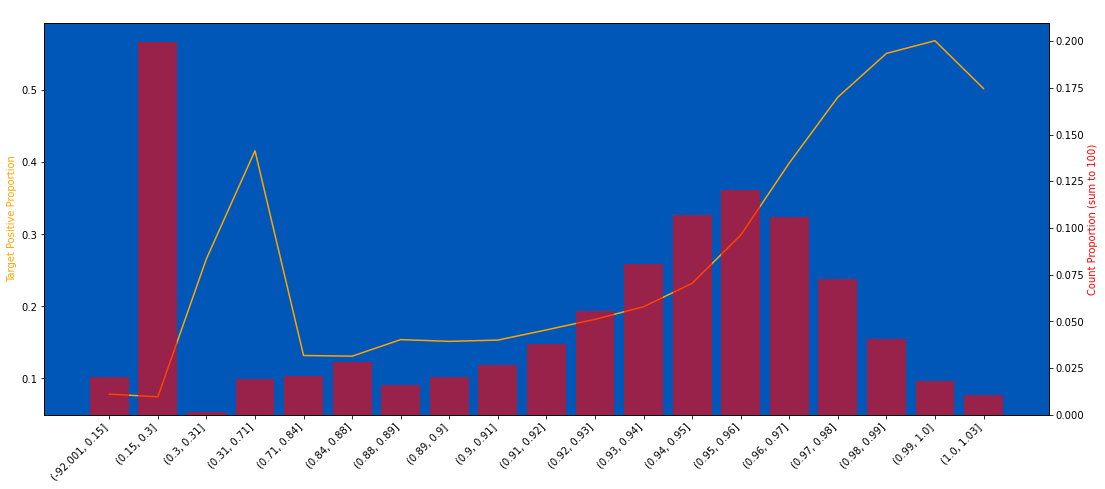

In [88]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


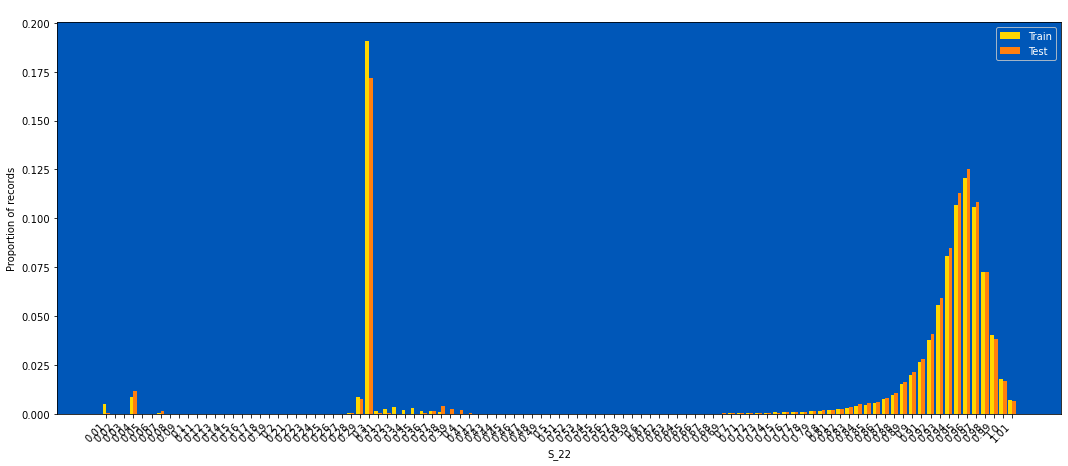

In [89]:
plot_train_test_distribution(train, test, "S_22", nunique_thr=777)

In [90]:
train.loc[train["S_22"].between(0.31, 0.39), "S_22"] = np.nan
test.loc[test["S_22"].between(0.31, 0.39), "S_22"] = np.nan

112660 null count, 0.020 null proportion
0.4032 of the targets have label = 1


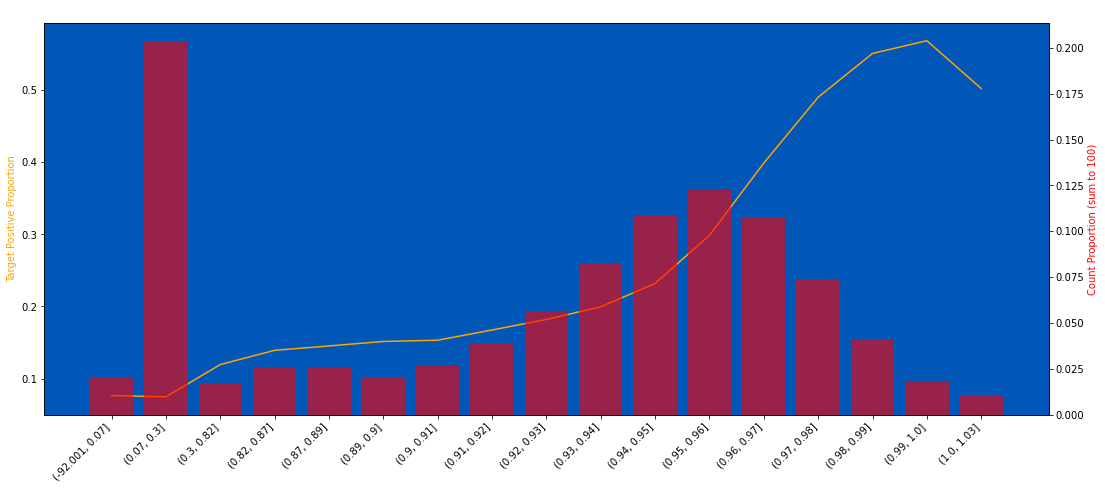

In [91]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, strfy_x=True)

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


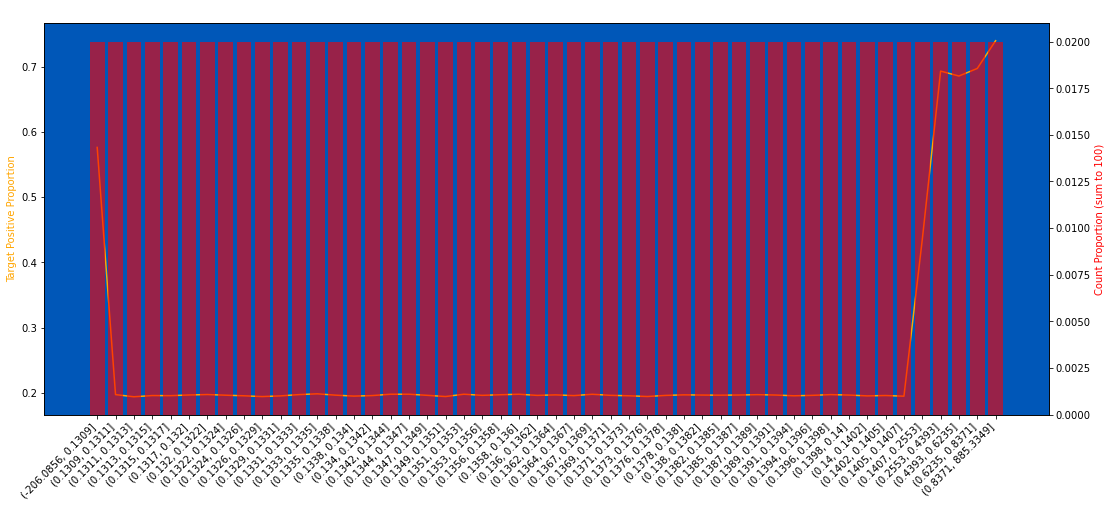

In [92]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [93]:
train["S_23"] = train["S_23"].round(2)
test["S_23"] = test["S_23"].round(2)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


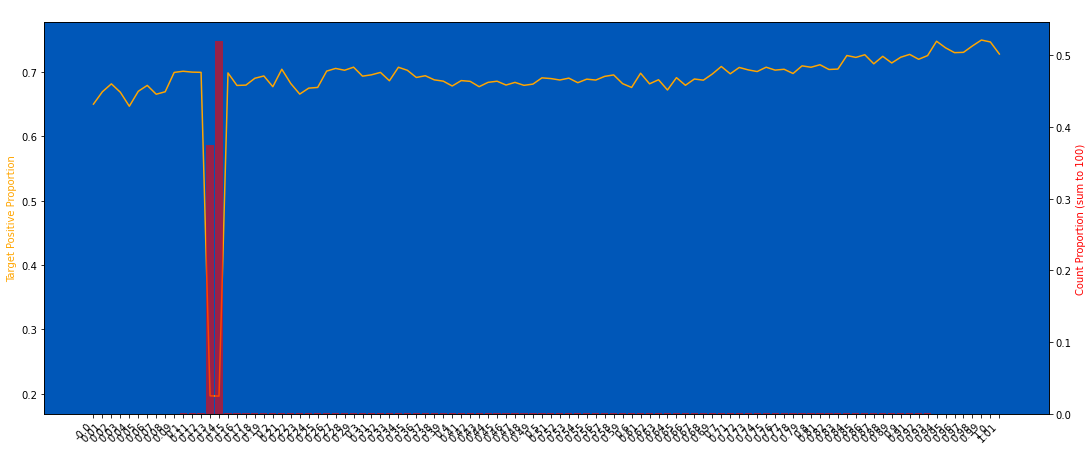

In [94]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

Bottom 1% and Top 1% are dropped from this chart


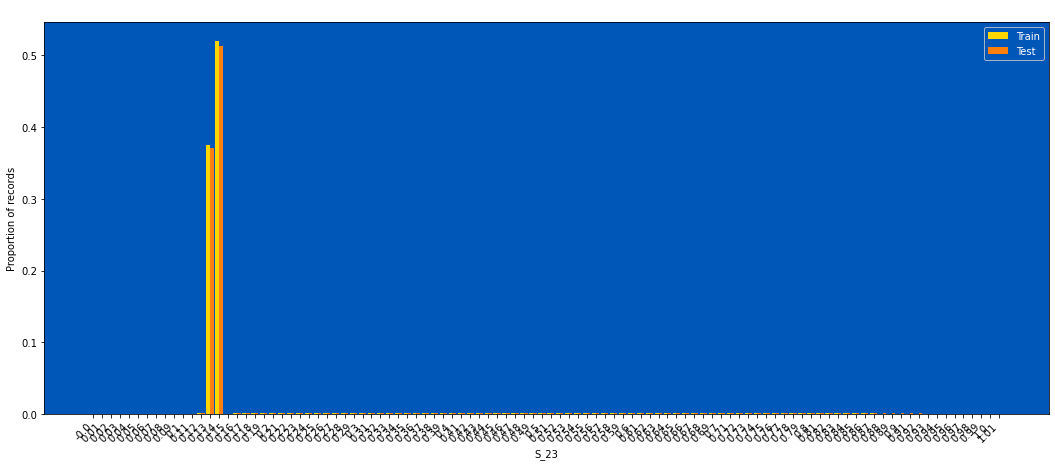

In [95]:
plot_train_test_distribution(train, test, "S_23", nunique_thr=1600)

In [96]:
train["S_23"] = train["S_23"].replace(0.13, np.nan).replace(0.14, np.nan)
test["S_23"] = test["S_23"].replace(0.13, np.nan).replace(0.14, np.nan)

4949043 null count, 0.895 null proportion
0.1966 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


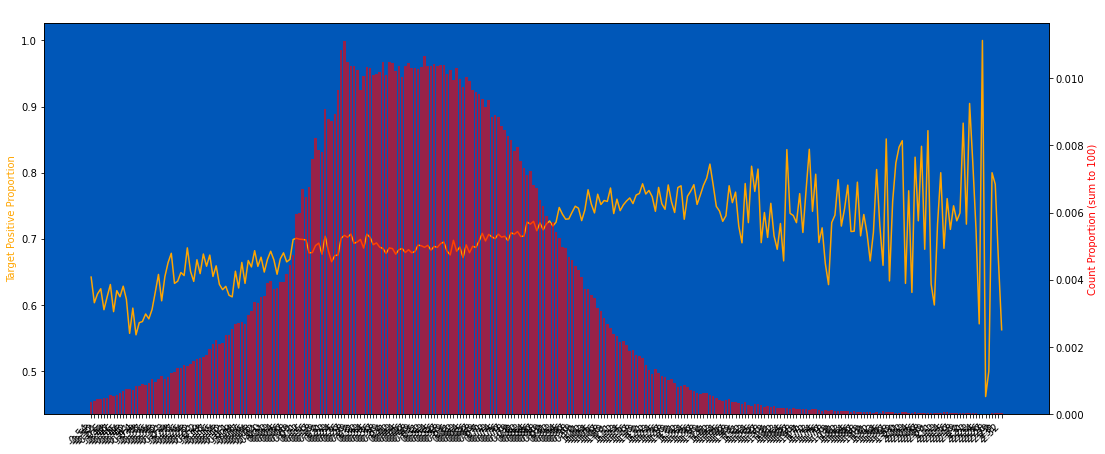

In [97]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


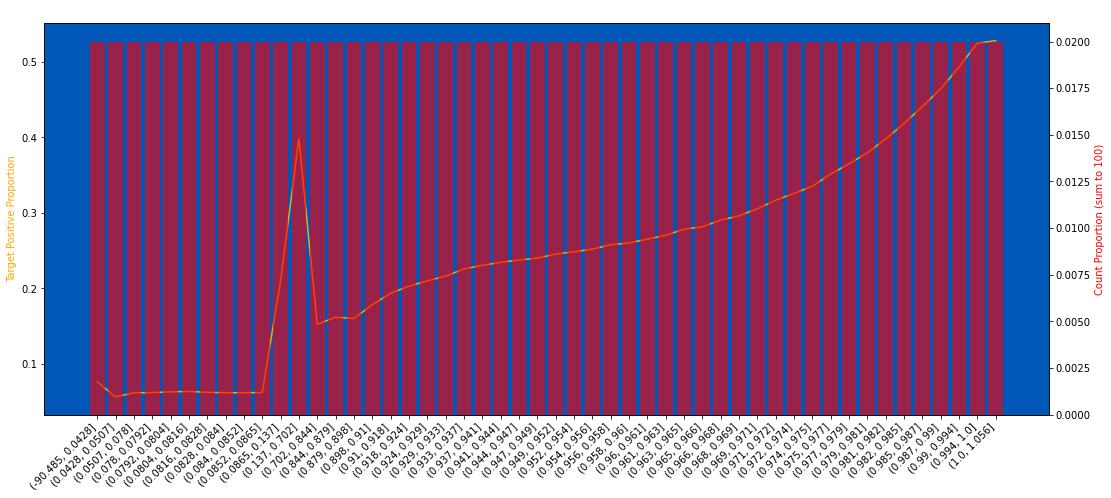

In [98]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [99]:
train["S_24"] = train["S_24"].round(2)
test["S_24"] = test["S_24"].round(2)

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


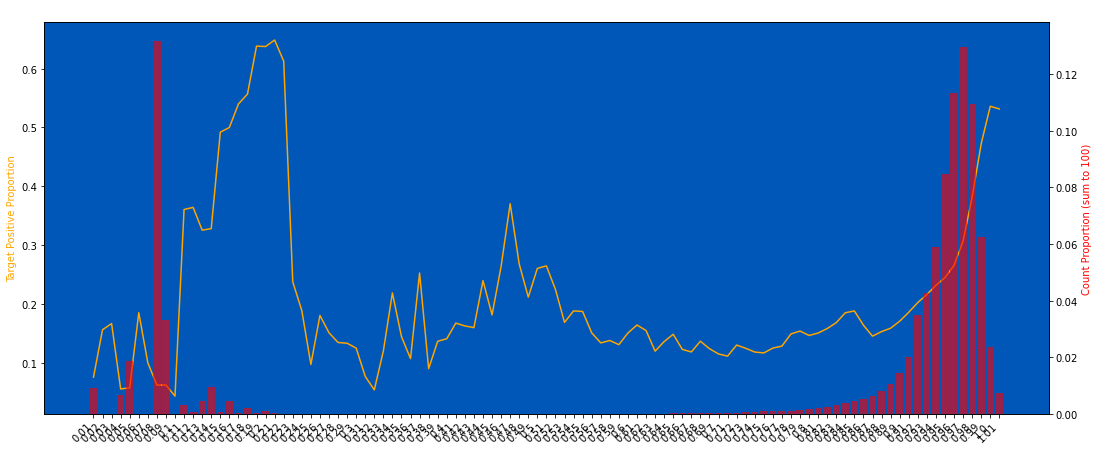

In [100]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

In [101]:
train.loc[train["S_24"].between(0.1, 0.65), "S_24"] = np.nan
test.loc[test["S_24"].between(0.1, 0.65), "S_24"] = np.nan

181216 null count, 0.033 null proportion
0.3611 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


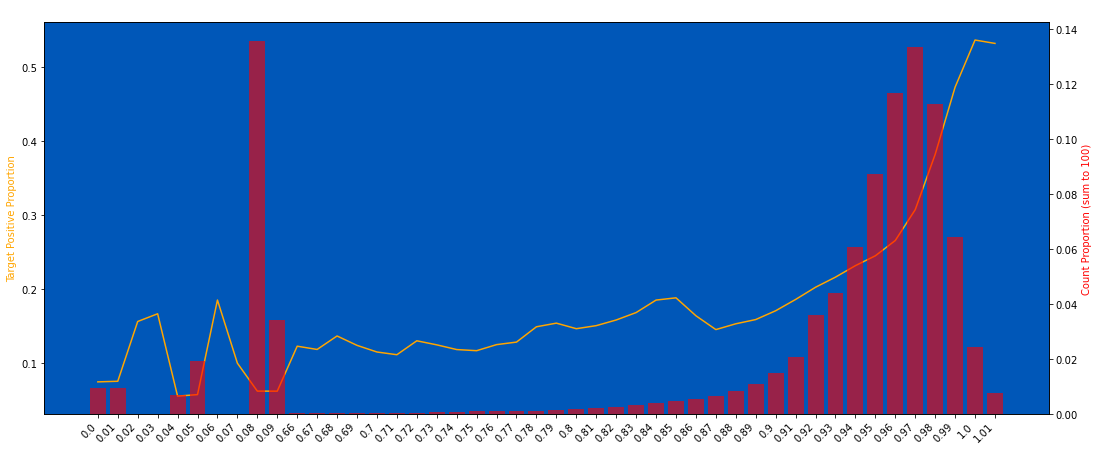

In [102]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


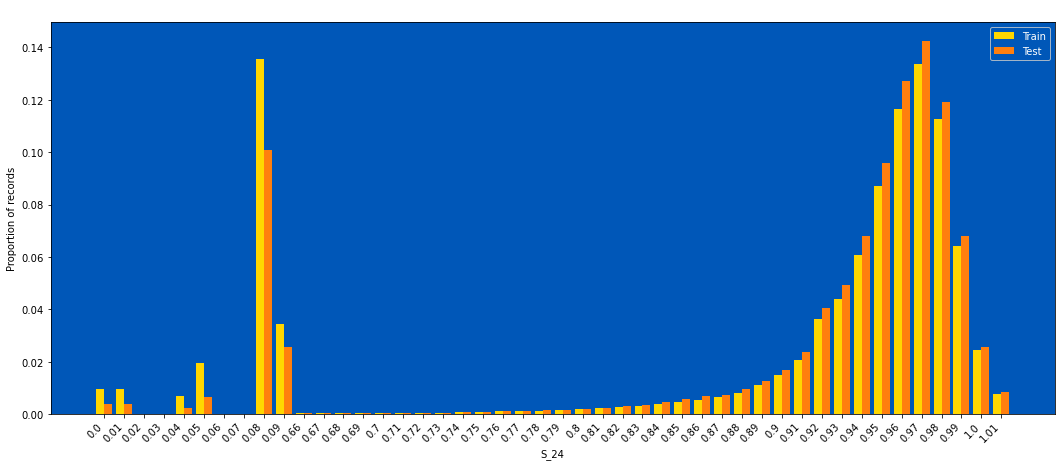

In [103]:
plot_train_test_distribution(train, test, "S_24", nunique_thr=650)

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


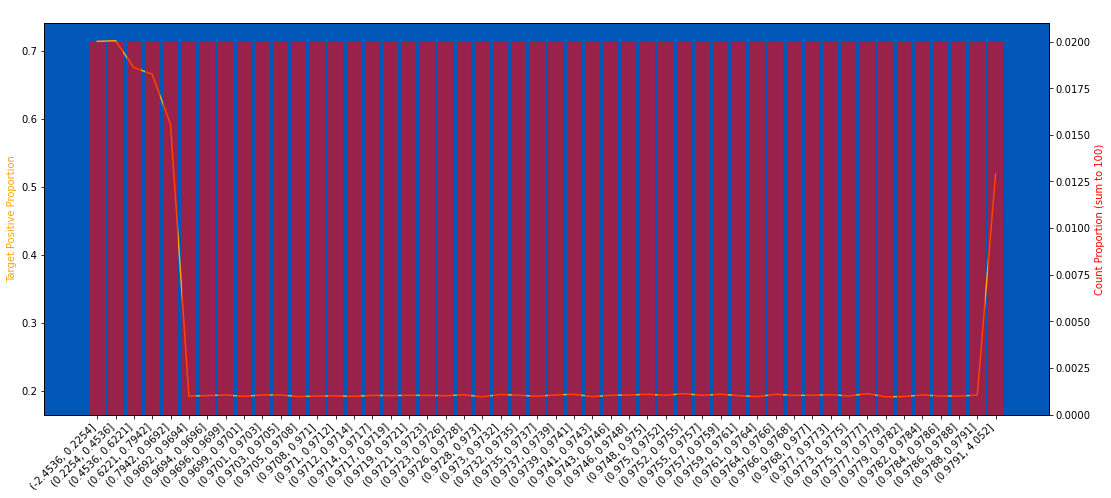

In [104]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [105]:
train["S_25"] = train["S_25"].round(2)
test["S_25"] = test["S_25"].round(2)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


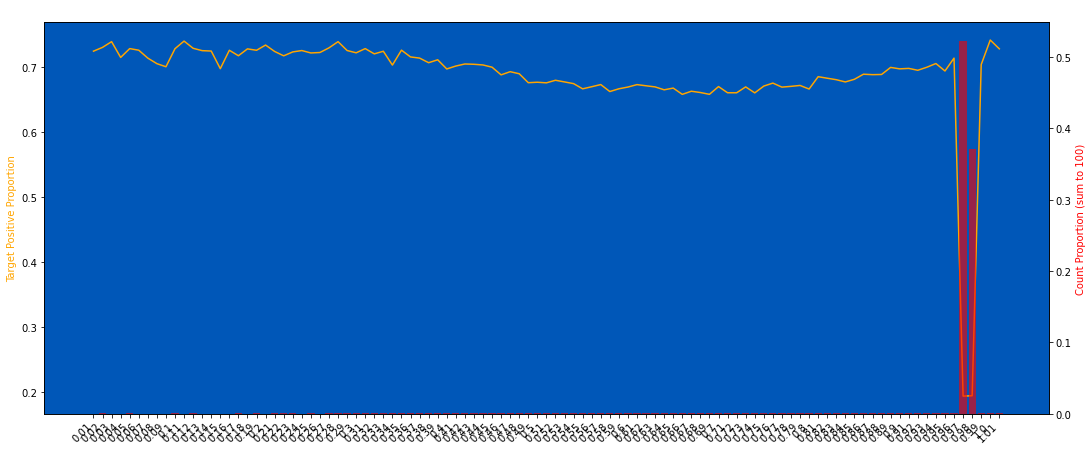

In [106]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


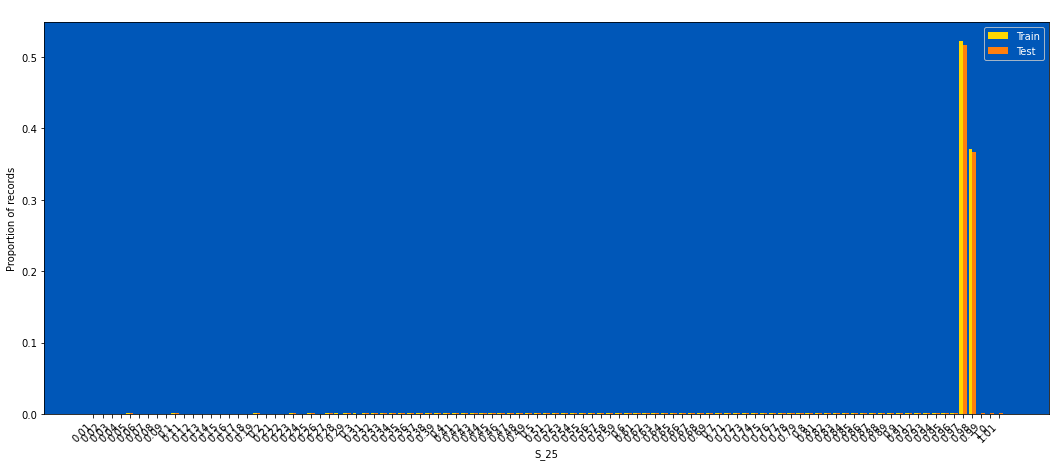

In [107]:
plot_train_test_distribution(train, test, "S_25", nunique_thr=1500)

In [108]:
train.loc[train["S_25"].between(0.97, 0.99), "S_25"] = np.nan
test.loc[test["S_25"].between(0.97, 0.99), "S_25"] = np.nan

4940675 null count, 0.893 null proportion
0.1954 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


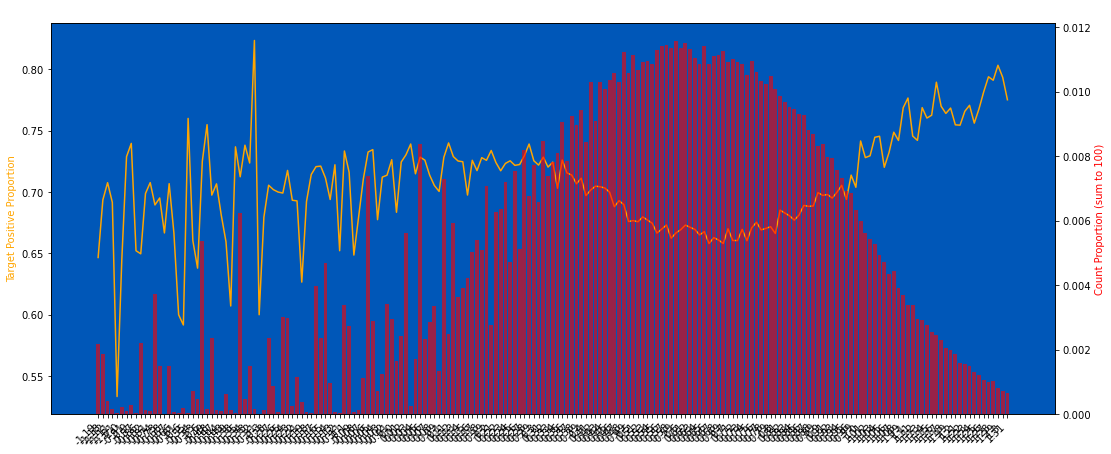

In [109]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


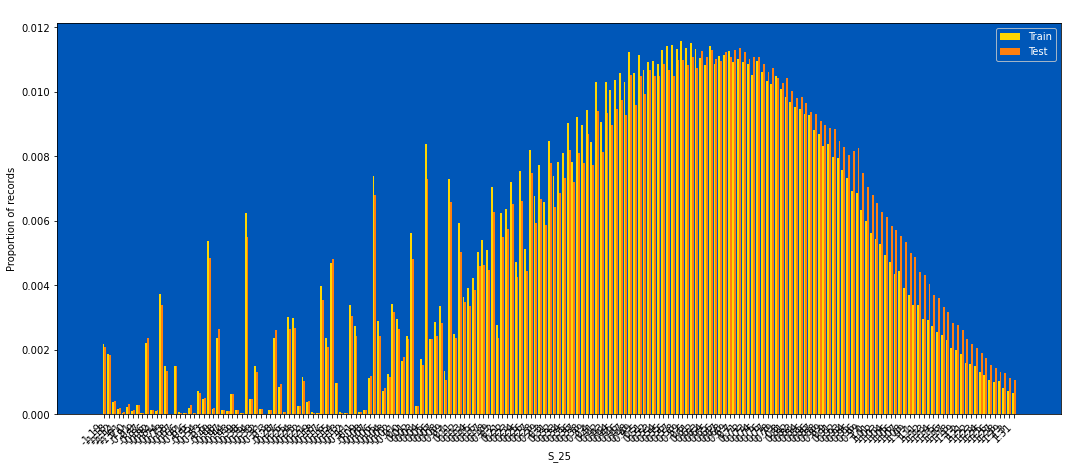

In [110]:
plot_train_test_distribution(train, test, "S_25", nunique_thr=1500)

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


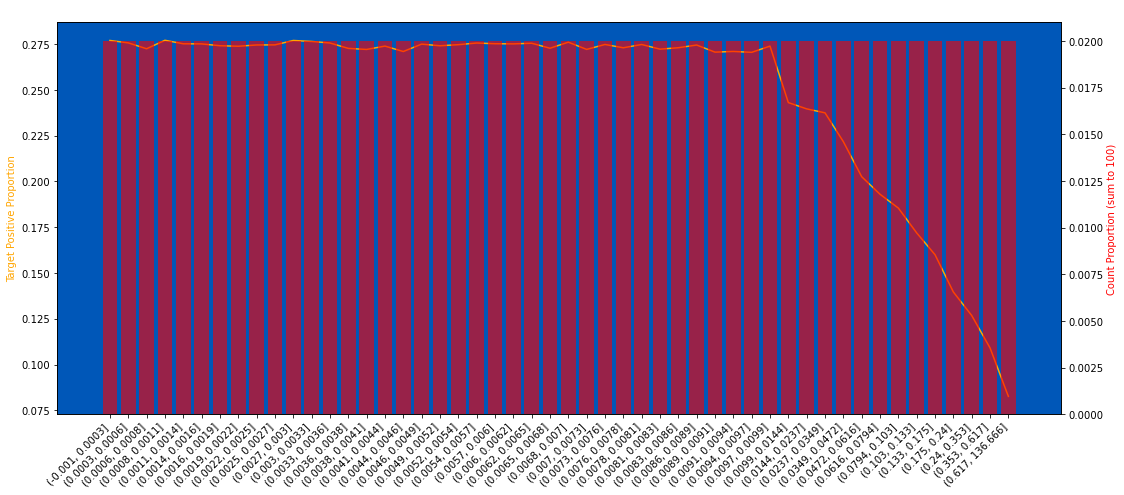

In [111]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [112]:
train["S_26"] = train["S_26"].round(2)
test["S_26"] = test["S_26"].round(2)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


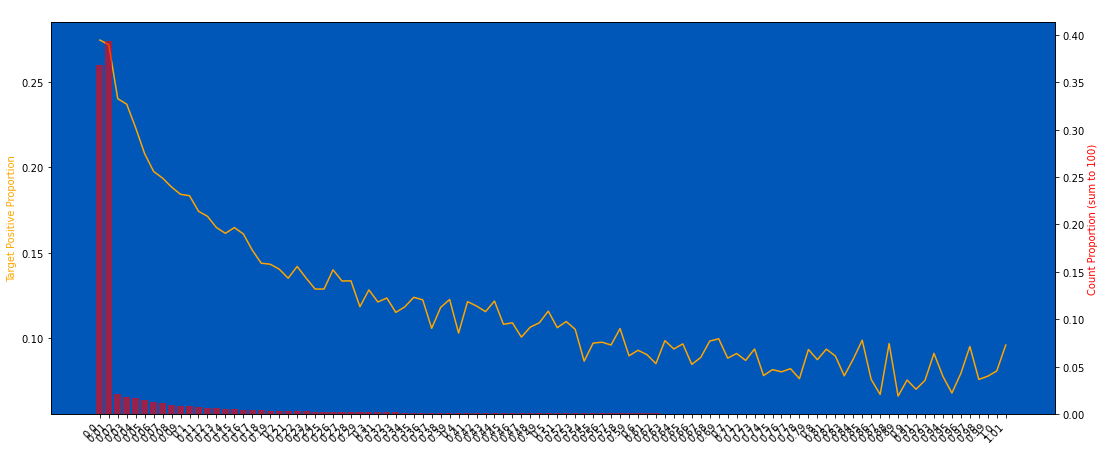

In [113]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


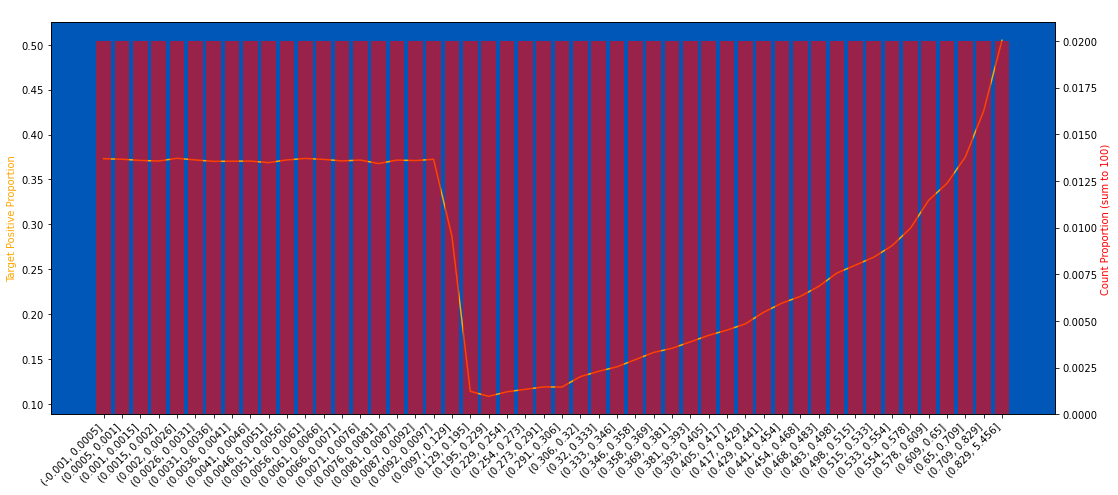

In [114]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [115]:
train["S_27"] = train["S_27"].round(2)
test["S_27"] = test["S_27"].round(2)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


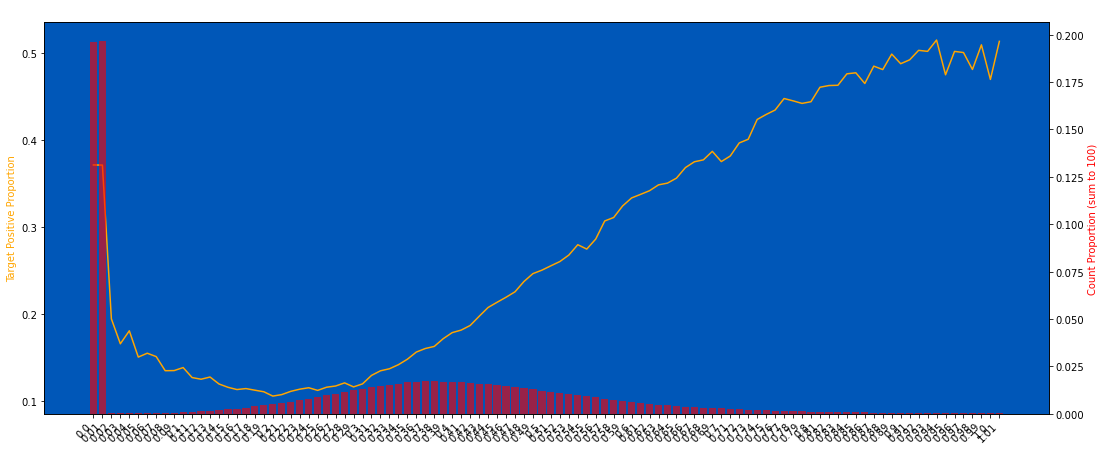

In [116]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

In [117]:
train.loc[train["S_27"].between(0, 0.02), "S_27"] = np.nan
test.loc[test["S_27"].between(0, 0.02), "S_27"] = np.nan

3024683 null count, 0.547 null proportion
0.2778 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


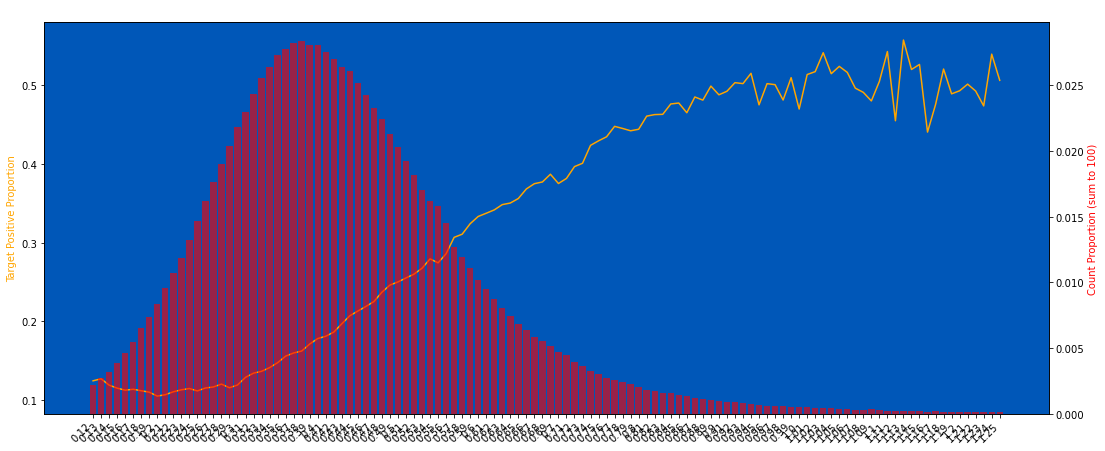

In [118]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


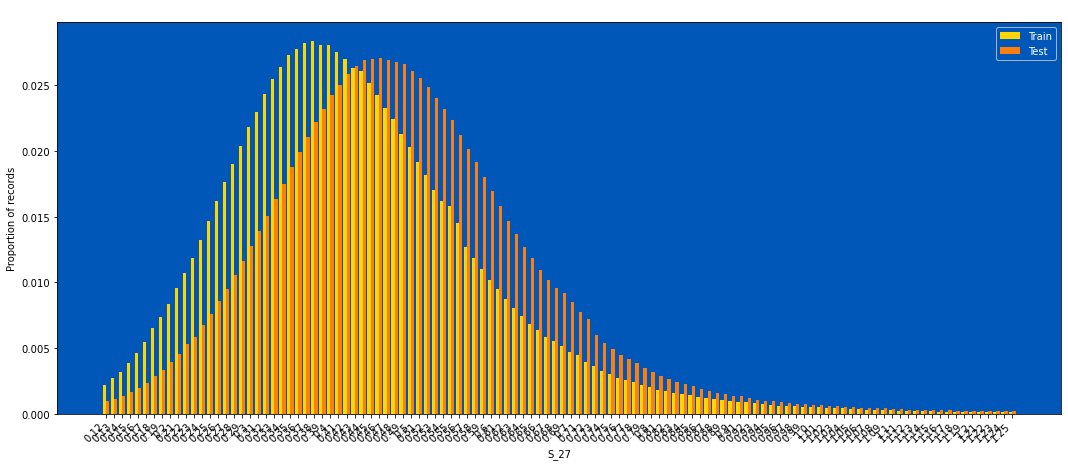

In [119]:
plot_train_test_distribution(train, test, "S_27", nunique_thr=1500)

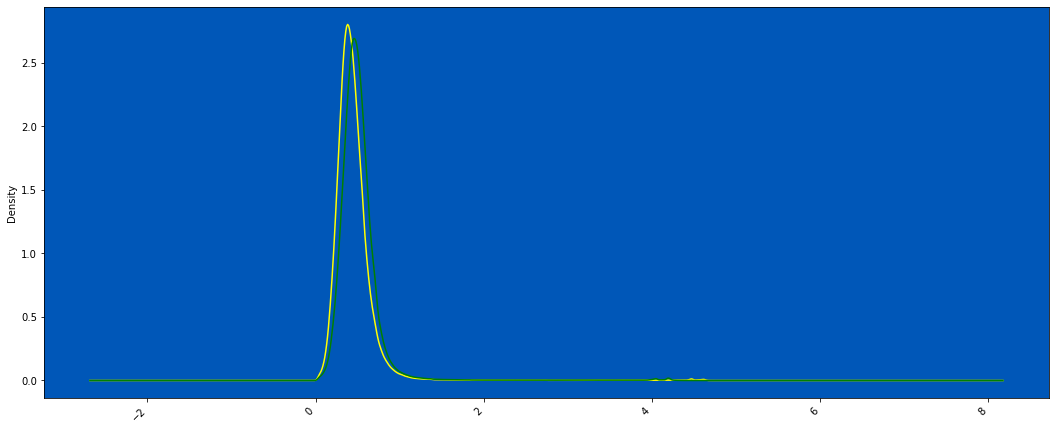

In [120]:
plot_train_test_distribution(train, test, "S_27", nunique_thr=100)

In [121]:
train["S_27"] = train["S_27"] * 1.055

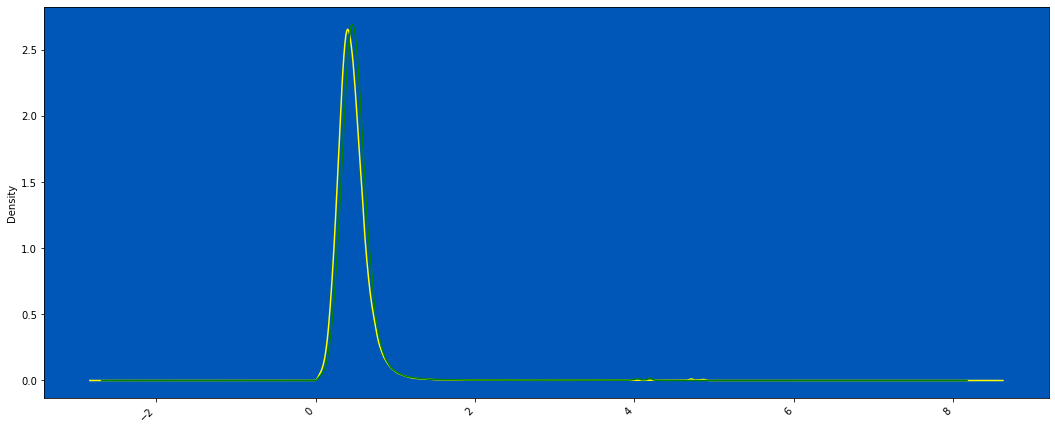

In [122]:
plot_train_test_distribution(train, test, "S_27", nunique_thr=100)

### Column checking

In [123]:
from tqdm import tqdm

In [124]:
all_columns = get_cols(train, ["P_", "S_"])

In [127]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -999)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -999)

  4%|█████                                                                                                                                  | 1/27 [00:00<00:15,  1.63it/s]

Train P_3 2


 41%|██████████████████████████████████████████████████████▌                                                                               | 11/27 [00:01<00:01,  9.75it/s]

Test P_3 13


 70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 19/27 [00:01<00:00, 18.57it/s]

Train S_22 4
Test S_22 5
Train S_23 21
Test S_23 46
Train S_24 3
Test S_24 11
Train S_25 138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.49it/s]

Test S_25 435


In [128]:
for d in tqdm(all_columns):
    train[d] = train[d].fillna(-127)
    test[d] = test[d].fillna(-127)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:11<00:00,  2.44it/s]


In [137]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -999, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-999, -1)
    neg1_series = test.loc[test[d] == -999, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-999, -1)

  4%|█████                                                                                                                                  | 1/27 [00:00<00:14,  1.83it/s]

Test P_3 13


 59%|███████████████████████████████████████████████████████████████████████████████▍                                                      | 16/27 [00:01<00:00, 12.66it/s]

Test S_22 5
Test S_23 46
Test S_24 11


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 22/27 [00:03<00:00,  5.90it/s]

Test S_25 435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.15it/s]


In [138]:
d_col_nunique = train[all_columns].nunique()

In [140]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 64].index.tolist()

In [142]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

S_6 : int16 
 [0, 1] 

S_8 : int16 
 [-127, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 

S_13 : int16 
 [-127, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 

S_15 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56] 

P_4 : float32 
 [-127.0, 0.7799999713897705, 0.7900000214576721, 0.800000011920929, 0.8100000023841858, 0.8199999928474426, 0.8299999833106995, 0.8399999737739563, 0.8500000238418579, 0.8600000143051147, 0.8700000047683716, 0.8799999952316284, 0.8899999856948853, 0.8999999761581421, 0.9100000262260437, 0.9200000166893005, 0.9300000071525574, 0.9399999976158142, 0.949999988079071, 0.9599999785423279, 0.9700000286102295, 0.9800000190734863, 0.9900000095367432, 1.0, 1.0099999904632568, 1.0199999809265137, 1.0299999713897705, 1.03999996185

In [143]:
# for col in tqdm(less_unique_d_cols):
#     train[col] = integerize(train[col])
#     test[col] = integerize(test[col])

In [145]:
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

In [146]:
train.shape, test.shape

((5531451, 193), (11363762, 192))

In [147]:
%%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_ps.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_ps.parquet")

CPU times: user 42.8 s, sys: 9.86 s, total: 52.7 s
Wall time: 46 s


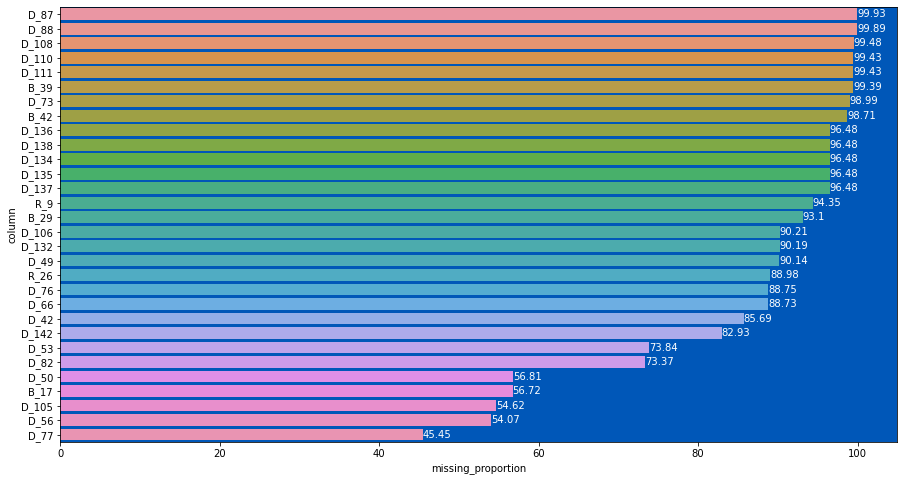

In [148]:
missing_df = plot_missing_proportion_barchart(train)

### Check Column

In [ ]:
(train["D_106"].round(1) - train["D_106"]).fillna(0).sum()